In [1]:
! pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7bb07dc661d0fe83d1d094e5dc9c07f5e584bbca80ad5663513592d92238329f
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=1460507efd964f43396c301696448c44d2cdd3fd2400f6ba1a3a73e9f0ea63b6
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyldavis sklearn


In [2]:
# Loading all necessary libraries
import numpy as np
import pandas as pd
import spacy
from time import time
from pprint import pprint

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# NLTK Stop words
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

pd.set_option('precision',3)
np.set_printoptions(precision = 4)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
from os import listdir
from os.path import isfile, join

mypath = 'drive/MyDrive/Scopus_Sport'

files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files

['scopus-10.csv',
 'scopus-11.csv',
 'scopus-12.csv',
 'scopus-3.csv',
 'scopus-5.csv',
 'scopus-6.csv',
 'scopus-7.csv',
 'scopus-8.csv',
 'scopus-9.csv',
 'scopus-4.csv',
 'scopus.csv',
 'scopus-top.csv',
 'representative_papers.xlsx',
 'full_with_topics.csv']

In [5]:
#files.remove('dtm-linux64')
#files.remove('data_vectorized.csv')
files.remove('representative_papers.xlsx')
files.remove('full_with_topics.csv')

df = pd.DataFrame()
for file in files:
    file = mypath + '/' + file
    df = pd.concat([df, pd.read_table(file, sep = ',', index_col = False)], ignore_index = True)
print('Initial size              :', df.shape)

df.rename(columns={"Авторы" : "Authors", "Название" : "Title", "Год" : "Year", "Название источника" : "Source", "Том" : "Volume",
                   "Выпуск " : "Issue", "Статья №" : "Article N", "Страница начала" : "Page_start", "Страница окончания" : "Page_end",
                   "Количество страниц" : "Pages", "Цитирования" : "Cited", "Ссылка" : "Link", "Краткое описание" : "Abstract", "Ключевые слова автора" : "Keywords",
                   "Язык оригинального документа" : "Language", "Тип документа" : "Type", "Источник" : "DB" }, inplace = True)

df.drop(['Pages','Link','Language','DB'], axis = 1, inplace = True)

df = df[df.Abstract != '[краткое описание не найдено]']    # Remove papers without abstract
df = df.drop_duplicates(subset = ["Title"])                                  # Drop duplicates

df.Year = df.Year.astype('int32')
df.Cited.fillna(0, inplace = True)
df.Cited = df.Cited.astype('int32')

print('Removing pubs w/o abstract:', df.shape)

df = df[df.Type == 'Article']
df.reset_index(drop=True, inplace=True)
print('Select only Articles      :',df.shape)

Initial size              : (17022, 17)
Removing pubs w/o abstract: (13857, 13)
Select only Articles      : (11707, 13)


In [6]:
# Selecting top journals 

print('Total number of sources:', len(df.Source.value_counts()))

Total number of sources: 1286


In [7]:
# Top sources by citation

df_so = pd.merge(df.groupby(by = 'Source').Source.count(), df.groupby(by = 'Source').Cited.sum(), 
                 left_index = True, right_index = True)
df_so.rename(columns = {'Source' : 'Pubs'}, inplace = True)
df_so['Avg_cit'] = df_so.Cited / df_so.Pubs
print('Source total                :', df_so.shape, 'pubs = ', df_so.Pubs.sum())

# Select sources
df_so = df_so[df_so.Pubs >= 10]
print('With 10 and more pubs       :', df_so.shape, 'pubs = ', df_so.Pubs.sum())

df_so = df_so[df_so.Avg_cit > 1.0]
print('Mean citation more than 1.0 :', df_so.shape, 'pubs = ', df_so.Pubs.sum())

Source total                : (1286, 3) pubs =  11707
With 10 and more pubs       : (185, 3) pubs =  8819
Mean citation more than 1.0 : (135, 3) pubs =  7393


In [8]:
df_so.sort_values(by = 'Avg_cit').head()

,Pubs,Cited,Avg_cit
Source,,,
Technical Textiles International,41,58,1.415
Asian Social Science,69,108,1.565
Sport Management Education Journal,61,99,1.623
Asian Textile Journal,15,26,1.733
Sport Mont,146,264,1.808


In [9]:
sources = df_so.index.values

df = df[df.Source.isin(sources)]
df.reset_index(drop=True, inplace=True)
df.shape

(7393, 13)

In [10]:
df.head()

,Authors,Title,Year,Source,Volume,Issue,Article N,Page_start,Page_end,Cited,Abstract,Keywords,Type
0,"Owen P.D., Ryan M., Weatherston C.R.",Measuring competitive balance in professional ...,2007,Review of Industrial Organization,31,4,NaN,289,302,57,Competitive balance in sports leagues is essen...,Competitive balance; Herfindahl-Hirschman inde...,Article
1,"Bissell K.L., Duke A.M.","Bump, set, spike: An analysis of commentary an...",2007,Journal of Promotion Management,13,1-2,NaN,35,53,38,Content analysis was employed to examine the c...,Audio commentary; Beach volleyball; Camera ang...,Article
2,"Jong W.J., Lee H.",Impacts of events on the brand Germany: Perspe...,2007,Event Management,11,3,NaN,145,153,6,This study explores the impacts of various eve...,Art event; Country brand; Country-of-origin co...,Article
3,Fisher G.,Swiss in novation: From spinnaker sails to art...,2007,Technical Textiles International,16,8,NaN,15,18,1,Technical textiles sector plays a vital role i...,NaN,Article
4,Hammond T.H.,Rank injustice?: How the scoring method for cr...,2007,Public Choice,133,3-4,NaN,359,375,10,The scoring method used by high schools and co...,Cross-country meets; Independence from irrelev...,Article


In [11]:
transport_papers = np.array([1 if 'transport' in paper.Abstract else 0 for index, paper in df.iterrows()])
(transport_papers > 0).sum()

40

In [12]:
print('Publication types: ', df.Type.unique())
print('Number of artciles: ', df[df.Type == 'Article'].Type.count())

Publication types:  ['Article']
Number of artciles:  7393


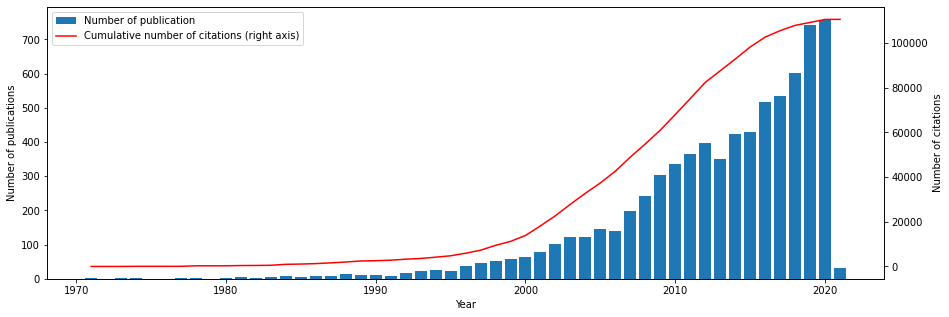

In [13]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.bar(df.groupby(by = 'Year').Year.count().index, df.groupby(by = 'Year').Title.count(), label = 'Number of publication')
ax2.plot(df.groupby(by = 'Year').Cited.sum().cumsum(), label = 'Cumulative number of citations (right axis)', c = 'r')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of publications')
ax2.set_ylabel('Number of citations')
ax2.grid(False)
_ = fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform = ax1.transAxes)

In [14]:
# Selecting publications in 2000-2020

df = df[df.Year > 1999]
df = df[df.Year < 2021]

df.reset_index(drop=True, inplace=True)
print('Select years 2000 - 2020:',df.shape)

transport_papers = np.array([1 if 'transport' in paper.Abstract else 0 for index, paper in df.iterrows()])
(transport_papers > 0).sum()

Select years 2000 - 2020: (6982, 13)


39

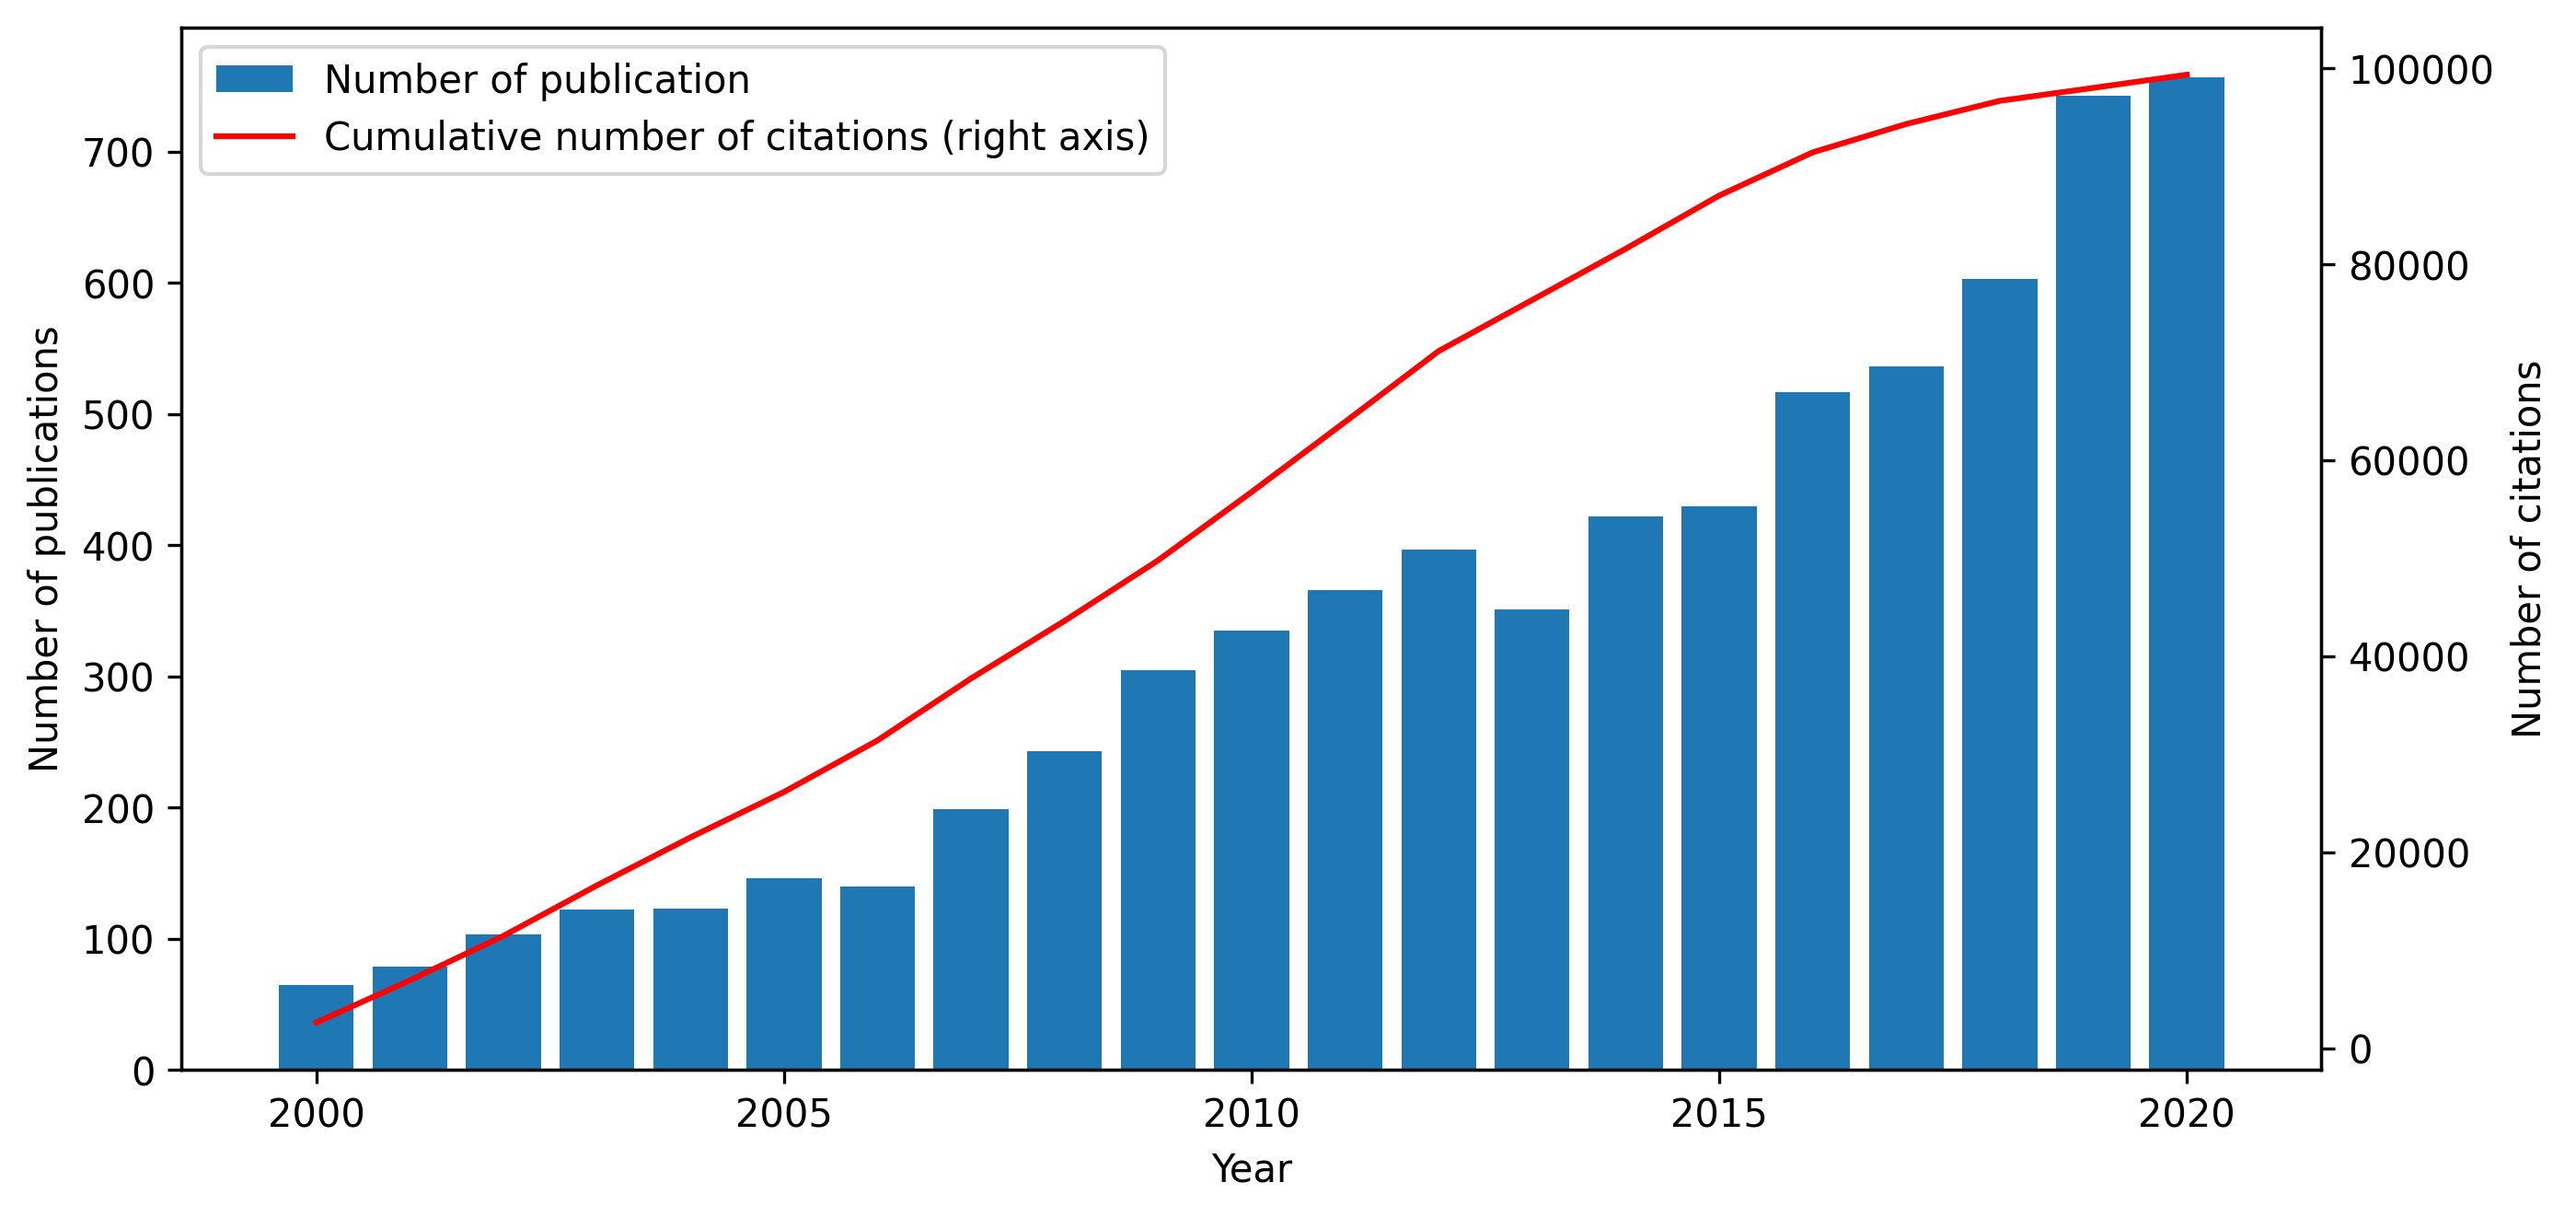

In [15]:
fig = plt.figure(figsize = (10,5), dpi = 300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.bar(df.groupby(by = 'Year').Year.count().index, df.groupby(by = 'Year').Title.count(), label = 'Number of publication')
ax2.plot(df.groupby(by = 'Year').Cited.sum().cumsum(), label = 'Cumulative number of citations (right axis)', c = 'r')
ax1.set_xticks(np.arange(2000,2021,5))
ax1.set_xticklabels(['2000', '2005', '2010','2015','2020'])
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of publications')
ax2.set_ylabel('Number of citations')
ax2.grid(False)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform = ax1.transAxes);

In [16]:
# Most cited papers:
df.sort_values(by = 'Cited', ascending = False)[['Authors','Year','Title','Source','Cited']].head(10)

,Authors,Year,Title,Source,Cited
288,Chalip L.,2006,Towards social leverage of sport events,Journal of Sport and Tourism,417
793,"Funk D.C., James J.",2001,The Psychological Continuum Model: A Conceptua...,Sport Management Review,415
125,Preuss H.,2007,The conceptualisation and measurement of mega ...,Journal of Sport and Tourism,360
331,"Lee C.-K., Lee Y.-K., Lee B.",2005,Korea's destination image formed by the 2002 W...,Annals of Tourism Research,325
665,Waitt G.,2003,Social impacts of the Sydney Olympics,Annals of Tourism Research,315
708,"Hightower Jr. R., Brady M.K., Baker T.L.",2002,Investigating the role of the physical environ...,Journal of Business Research,303
632,"Borland J., Macdonald R.",2003,Demand for sport,Oxford Review of Economic Policy,286
180,"Füller J., Jawecki G., Mühlbacher H.",2007,Innovation creation by online basketball commu...,Journal of Business Research,274
592,"Gwinner K., Swanson S.R.",2003,A model of fan identification: Antecedents and...,Journal of Services Marketing,270
242,"Kim H.J., Gursoy D., Lee S.-B.",2006,The impact of the 2002 World Cup on South Kore...,Tourism Management,255


In [17]:
paper_ind = 288
paper_ = df.loc[paper_ind]
print(paper_[0], '({:4d})'.format(paper_[2]), paper_[1],'.', paper_[3], '.',
      '{:3s}({:2s}):{:4s} - {:4s}'.format(paper_[4], paper_[5], paper_[7], paper_[8]),
      'cited {:5d}'.format(paper_[9]))
print()
print(paper_[10])

Chalip L. (2006) Towards social leverage of sport events . Journal of Sport and Tourism . 11 (2 ):109  - 127  cited   417

Despite the predominant policy focus on event economic impact, event organisers and host community residents are calling for attention to be paid to the social value of events. Anthropological work on events demonstrates that their celebratory nature engenders a liminoid space that can foster social value, particularly through a sense of communitas. In order to enable and amplify liminality and communitas, event organisers and host community planners should foster social interaction and prompt a feeling of celebration by enabling sociability among event visitors, creating event-related social events, facilitating informal social opportunities, producing ancillary events, and theming widely. The resulting narratives, symbols, meanings, and affect can then be leveraged to address social issues, build networks, and empower community action. These may be furthered when

In [18]:
# Most productive authors

auth_list = df.Authors.apply(lambda x: x.split('.,'))

authors = {}

for alist in auth_list:
    for a in alist:
        a_s = a.strip()
        if a_s[-1] == '.':
            a_s = a_s[:-1]
        if a_s in authors:
            authors[a_s] += 1
        else:
            authors[a_s] = 1

print('Total {:5d} authors'.format(len(authors)))

Total  9388 authors


In [19]:
authors = {k: v for k, v in sorted(authors.items(), key=lambda item: item[1])}

productive_authors = list(authors.keys())[-11:]
for a in productive_authors:
    print(a, authors[a])

Parent M.M 33
Dickson G 33
Hallmann K 33
Kim M 34
Kaplanidou K 35
Heere B 35
Ko Y.J 37
Humphreys B.R 38
Funk D.C 55
Breuer C 61
Wicker P 67


In [20]:
authors_citation = {'author' : [], 'papers' : [], 'citations' : []}

for a in authors:
    mask_auth = df['Authors'].str.contains(a)
    authors_citation['author'].append(a)
    authors_citation['citations'].append(df[mask_auth].Cited.sum())
    authors_citation['papers'].append(df[mask_auth].shape[0])

<ipython-input-20-5565a4e2f617>:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  mask_auth = df['Authors'].str.contains(a)


In [21]:
authors_citation1 = pd.DataFrame(authors_citation)
authors_citation1['avg_citation'] = authors_citation1.citations / authors_citation1.papers
authors_citation2 = authors_citation1[authors_citation1.papers >= 10].sort_values(by = 'avg_citation', ascending = False).head(10)
authors_citation2

,author,papers,citations,avg_citation
9182,Preuss H,10,713,71.300
9367,Chalip L,28,1771,63.250
9263,Gibson H.J,13,733,56.385
8962,James J,33,1740,52.727
9180,Christine Green B,10,492,49.200
9278,Szymanski S,14,669,47.786
8985,Lee C,14,664,47.429
9385,Funk D.C,55,2571,46.745
9285,Gibson H,27,1220,45.185
9362,James J.D,27,1218,45.111


In [22]:
# Bag-of_word preparation

data = df.Abstract.tolist()

In [23]:
# Tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=2, max_len=15))  # deacc=True removes punctuations
t0 = time()
data_words = list(sent_to_words(data))
print('Done in %.2f s' %(time() - t0))

Done in 3.29 s


In [24]:
# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                                   for token in doc if token.pos_ in allowed_postags]))
    return texts_out

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
t0 = time()
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN']) #, 'ADJ', 'VERB', 'ADV'])
print('Done in %.2f s' %(time() - t0))

Done in 99.53 s


In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
# Removing stop words
def remove_stopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc), deacc = True, min_len=2, max_len=15) if word not in stop_words] for doc in texts]

stop_words = stopwords.words('english')
stop_words.extend(['research','study','findings','implication','paper','article','author','authors','model','framework',
                   'result','approach','methodology','method','purpose','use','publish','journal','novelty','book','science',
                   'whiley', 'john', 'son','igi','review','theory','work','literature','elsevier','ltd', 'published'])
stop_words.extend(['performance','activity','value','management','sport','group','organization','product','development',
                   'expirience','relationship','intention','effect','analysis'])
stop_words.extend(['francis','taylor'])

t0 = time()
data_words_nostops = remove_stopwords(data_lemmatized, stop_words)
print('Done in %.2f s' %(time() - t0))

Done in 2.64 s


In [27]:
# Make bigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
t0 = time()
data_words_bigrams = make_bigrams(data_words_nostops)
print('Done in %.2f s' %(time() - t0))

Done in 0.79 s


In [28]:
def convert_to_string(texts):
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join([term for term in sent]))
    return texts_out

t0 = time()
data_raw = convert_to_string(data_words_bigrams)                         
print('Done in %.2f s' %(time() - t0))   

Done in 0.03 s


In [29]:
# Create Document-Word Matrix
# This cell can be skipped since vecorization paramters are opimized below

vectorizer = CountVectorizer(analyzer='word',       
                             min_df = 0.025,                    # minimum reqd occurences of a word in corpus
                             max_df = 0.95,                    # remove corpus-specific stop words
                             stop_words='english',             # remove stop words yet another time
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             ngram_range = (1,2),              # create unigrams and bigrams
                             max_features=300,                 # max number of uniq words
                            )
t0 = time()
data_vectorized = vectorizer.fit_transform(data_raw)
print('Done in %.2f s' %(time() - t0))
print(data_vectorized.shape)

Done in 1.28 s
(6982, 279)


In [ ]:
#pd.DataFrame.sparse.from_spmatrix(data_vectorized, columns = vectorizer.get_feature_names()).to_csv(mypath + '/data_vectorized.csv', index = False)

In [30]:
# Compute Sparsicity = Percentage of Non-Zero cells
data_dense = data_vectorized.todense()
print("Sparsicity: %.2f" %(((data_dense > 0).sum()/data_dense.size)*100), "%")

Sparsicity: 5.99 %


In [31]:
# Computing coherence using Palmetto Web service

import requests
import logging 

logging.captureWarnings(True)

def coherence(words, coherence_type = 'cv'):
    palmetto_uri = 'http://palmetto.aksw.org/palmetto-webapp/service/'
    request_uri = palmetto_uri + coherence_type + '?words=' + '%20'.join(words).replace(' ','%20')
    r = requests.get(request_uri, timeout=60, verify = False)
    if(not r.ok):
        return r.status_code
    else:
        return r.text

In [32]:
import itertools

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [33]:
def show_topics(lda_model, vectorizer=vectorizer,  n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [34]:
perplexity = {}
coherences = {}
overlapping = {}
lda_models = {}
topics = {}
for n in range(8,9): # range(2,21)
    start = time()
    lda = LatentDirichletAllocation(n_components = n,           
                                    learning_method = 'online',   
                                    random_state = 100,
                                    n_jobs = -1,
                                    doc_topic_prior = None,
                                    topic_word_prior = None,
                                    learning_decay = 0.7,
                                    max_iter = 10,
                                    batch_size = 128)
    lda.fit(data_vectorized) 
    lda_models[n] = lda
    perplexity[n] = lda.perplexity(data_vectorized)
    
    topic_keywords = show_topics(lda_model=lda, vectorizer=vectorizer, n_words=20)
    topics[n] = topic_keywords

  
    jaccard_sims = []
    for topic1,topic2 in itertools.combinations(topic_keywords, 2):
      jaccard_sims.append(jaccard_similarity(topic1, topic2))        
    
    overlapping[n] = np.array(jaccard_sims).mean()

#    coh = []
#    for words in topic_keywords:
#      coh.append(float(coherence(words, coherence_type = 'cv')))

#    coherences[n] = np.array(coh).mean()
    
    print('N_topics = {:2d}: perplexity = {:6.1f} overlapping = {:.3f} [{:.1f} s]'.format(n,  
                                                                                          perplexity[n], 
                                                                                          overlapping[n],
                                                                                          time() - start))
  

  warnings.warn(msg, category=FutureWarning)



N_topics =  8: perplexity =  176.6 overlapping = 0.024 [24.3 s]


In [35]:
from gensim.models import Word2Vec

start = time()
w2v_model = Word2Vec(sentences = data_words_bigrams, window = 5, min_count=1, workers=4)
print(time() - start)

5.6951422691345215


In [36]:
coherences = {}
for n in topics:
  coh = []
  for topic in topics[n]:
    pair_scores = []
    for pair in itertools.combinations(topic, 2):
      pair_scores.append(w2v_model.similarity(pair[0].split()[0], pair[1].split()[0]))
    topic_score = sum(pair_scores) / len(pair_scores)
    coh.append(topic_score)
  coherences[n] = sum(coh) / len(coh)
  print('N topics = {:2d} coherence = {:.3f}'.format(n, coherences[n]))

N topics =  8 coherence = 0.669


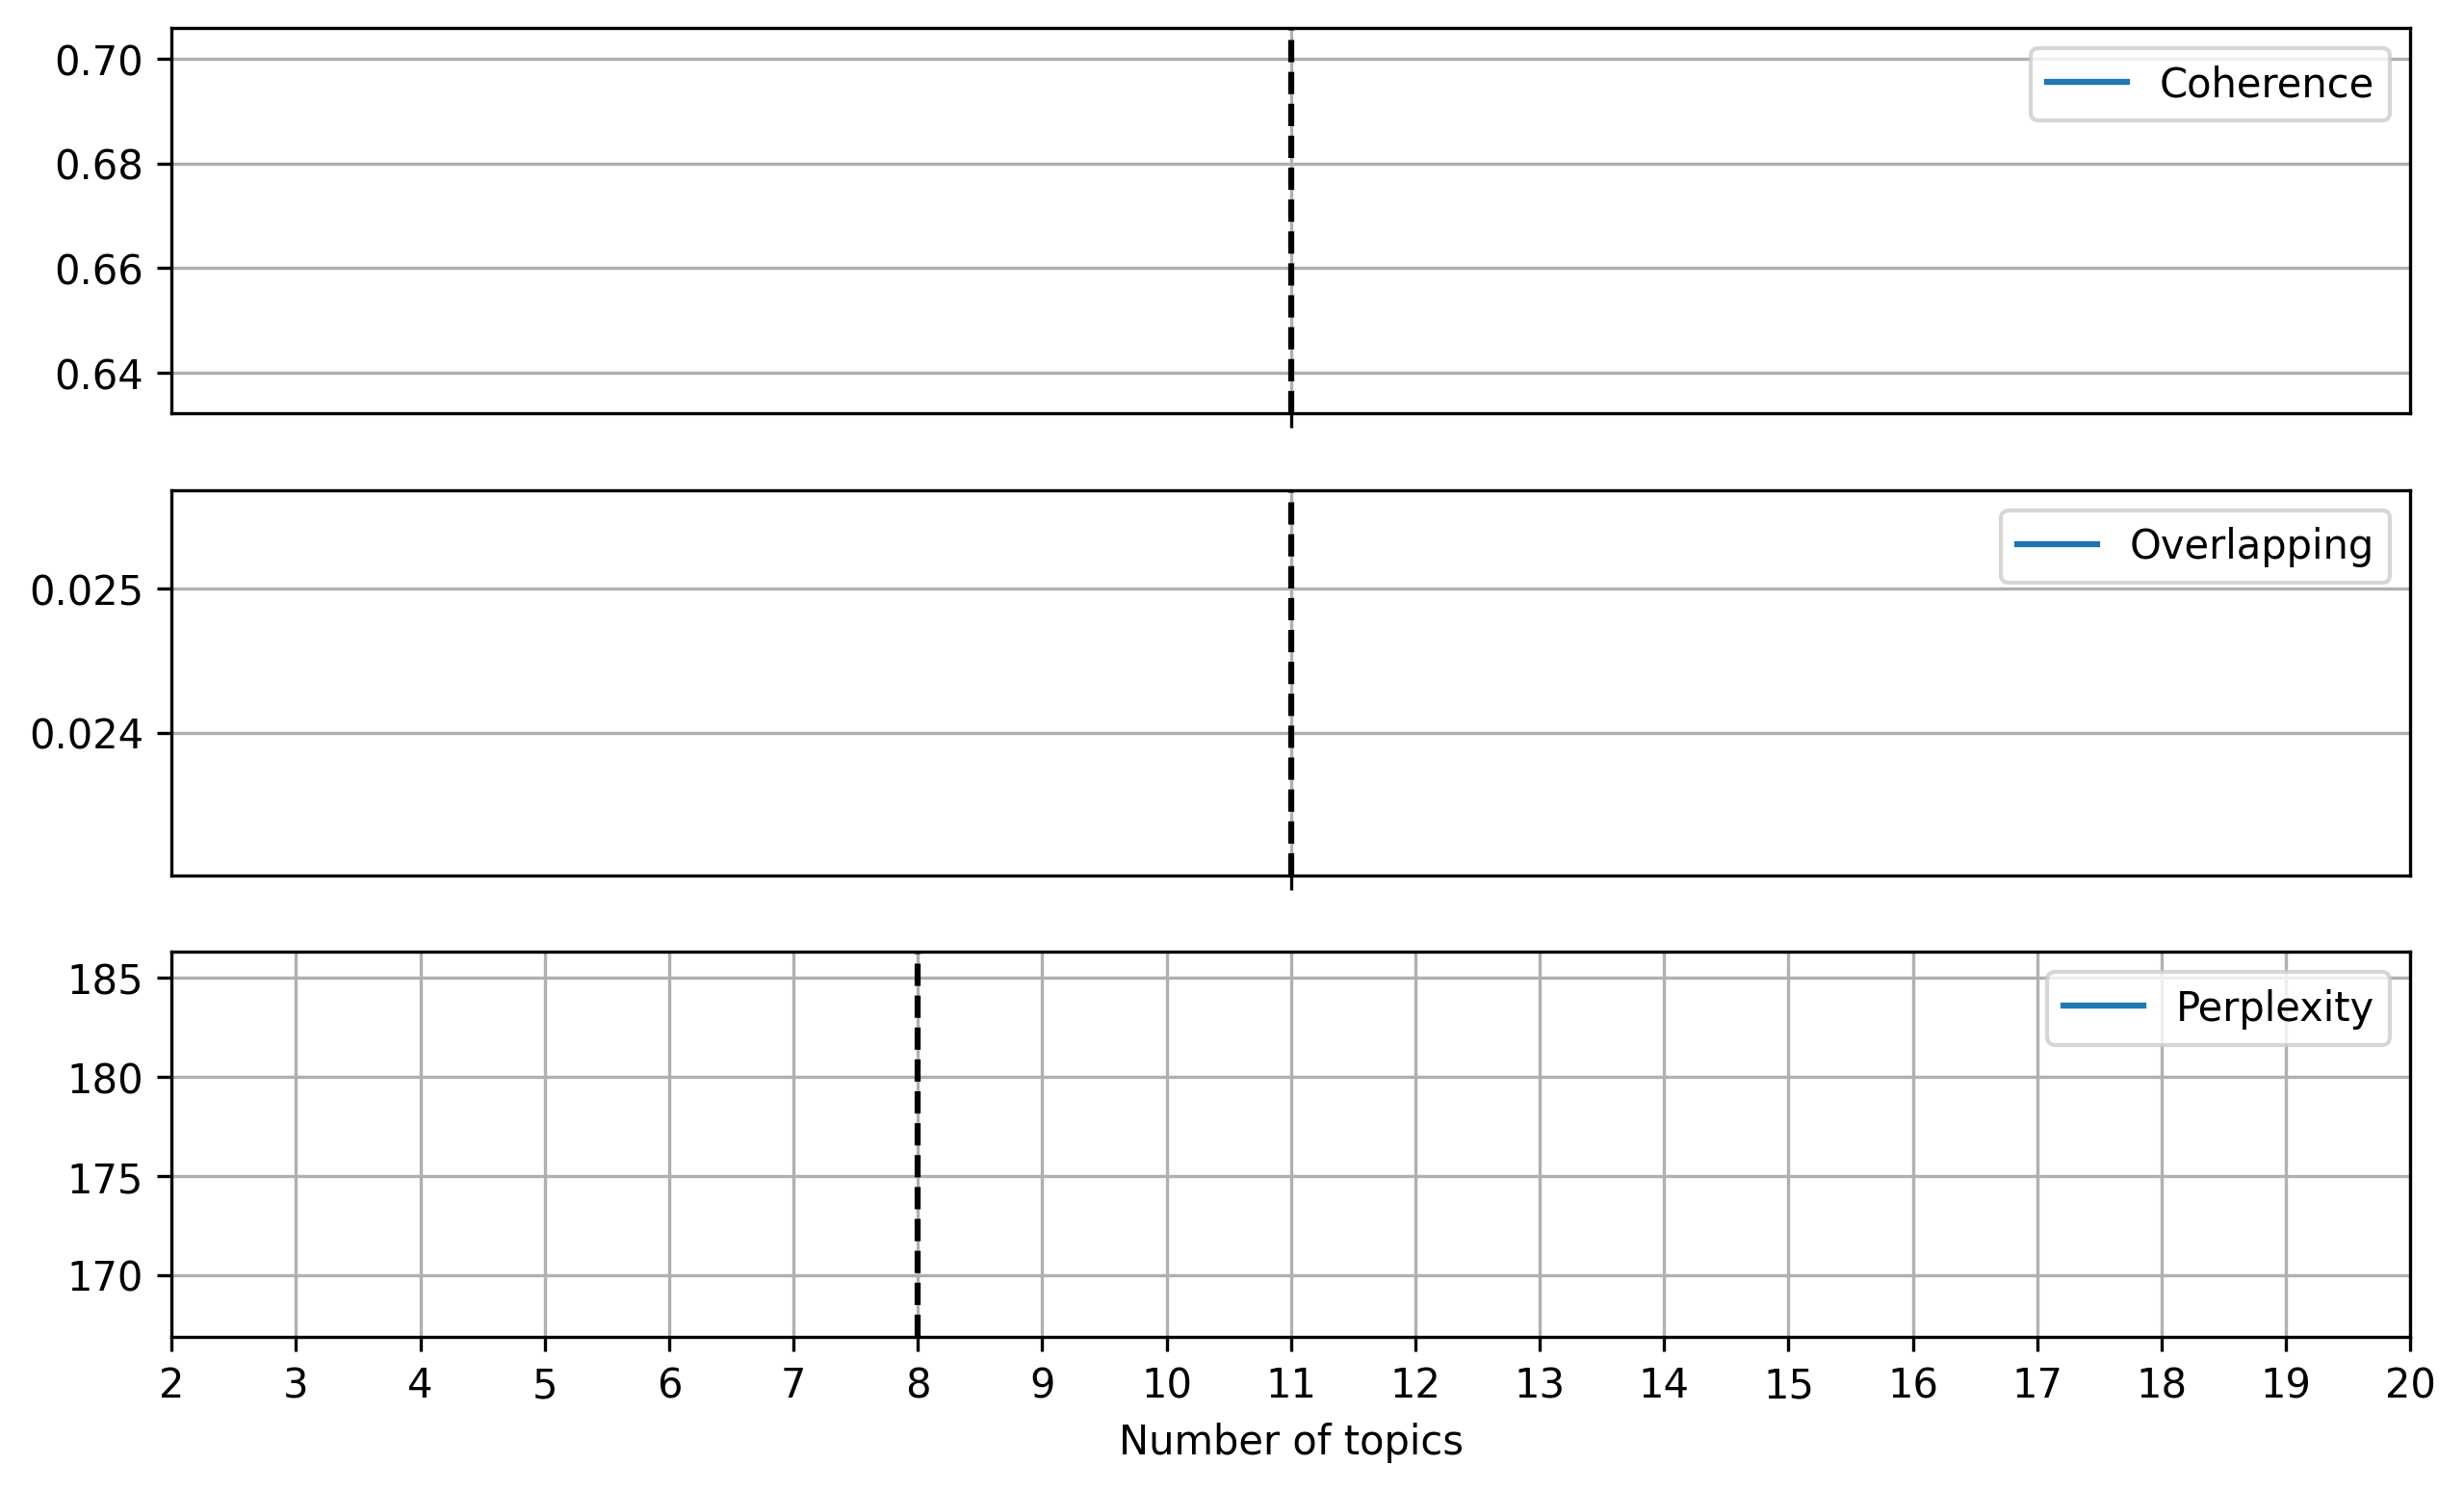

In [37]:
fig, axes = plt.subplots(figsize = (10,6), nrows=3, sharex=True, dpi = 300)

axes[0].plot(list(coherences.keys()), list(coherences.values()), label = 'Coherence')
axes[0].axvline(8, c = 'k', ls = '--')
axes[0].legend()
axes[0].grid()

axes[1].plot(list(overlapping.keys()), list(overlapping.values()), label = 'Overlapping')
axes[1].axvline(8, c = 'k', ls = '--')
axes[1].grid()
axes[1].legend()

axes[2].plot(list(perplexity.keys()), list(perplexity.values()), label = 'Perplexity')
axes[2].axvline(8, c = 'k', ls = '--')
axes[2].legend()
axes[2].grid()

_ = axes[2].set_xlabel('Number of topics');
axes[2].set_xticks(np.linspace(2,20,19));

In [38]:
for n in topics:
  print('{:2d}: coh = {:.3f} over = {:.3f} per = {:.1f}'.format(n, coherences[n], overlapping[n], perplexity[n]))


 8: coh = 0.669 over = 0.024 per = 176.6


In [39]:
best_num_of_topics = 8
lda_model = lda_models[best_num_of_topics]

In [40]:
# Interactive tool for topics visuaization and analysis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel;

  default_term_info = default_term_info.sort_values(

  warnings.warn(

  warnings.warn(

  warnings.warn(



In [41]:
lda_output = lda_model.transform(data_vectorized)

#topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
#topicnames = ['Performance management', 'Sport events','Fans and Advertisement', 'Strength and Motivation',
#              'Social impact', 'Psychology', 'Participation patterns', 'Dependency Analysis']

topicnames = ['Sport for Development', 'Sport Performance', 'Sport Diversity', 'Customer Behaviour', 
              'Sport Events', 'Social Context', 'Fans Loyalty', 'Sport Marketing']


df_document_topic = pd.DataFrame(lda_output, columns=topicnames, index = df.index)
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.shape

(6982, 9)

In [42]:
# Number of documents by dominant topic
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution['Topic Name'] = [topicnames[i] for i in df_topic_distribution['Topic Num'].values]
df_topic_distribution

,Topic Num,Num Documents,Topic Name
0,5,1470,Social Context
1,2,1181,Sport Diversity
2,7,975,Sport Marketing
3,1,898,Sport Performance
4,4,760,Sport Events
5,0,745,Sport for Development
6,6,742,Fans Loyalty
7,3,211,Customer Behaviour


In [43]:
# Building wordcloud for each topic
n_words = 20

keywords_frequency = []
words_weights_by_topic = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
keywords = np.array(vectorizer.get_feature_names())

for topic in words_weights_by_topic:
    topic_words_frequency = {}
    for word, freq in zip(keywords, topic):
        topic_words_frequency.update({word : freq})
    keywords_frequency.append(topic_words_frequency)

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: mcolors.XKCD_COLORS

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_words,
                  colormap='tab10',
#                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

  warnings.warn(msg, category=FutureWarning)



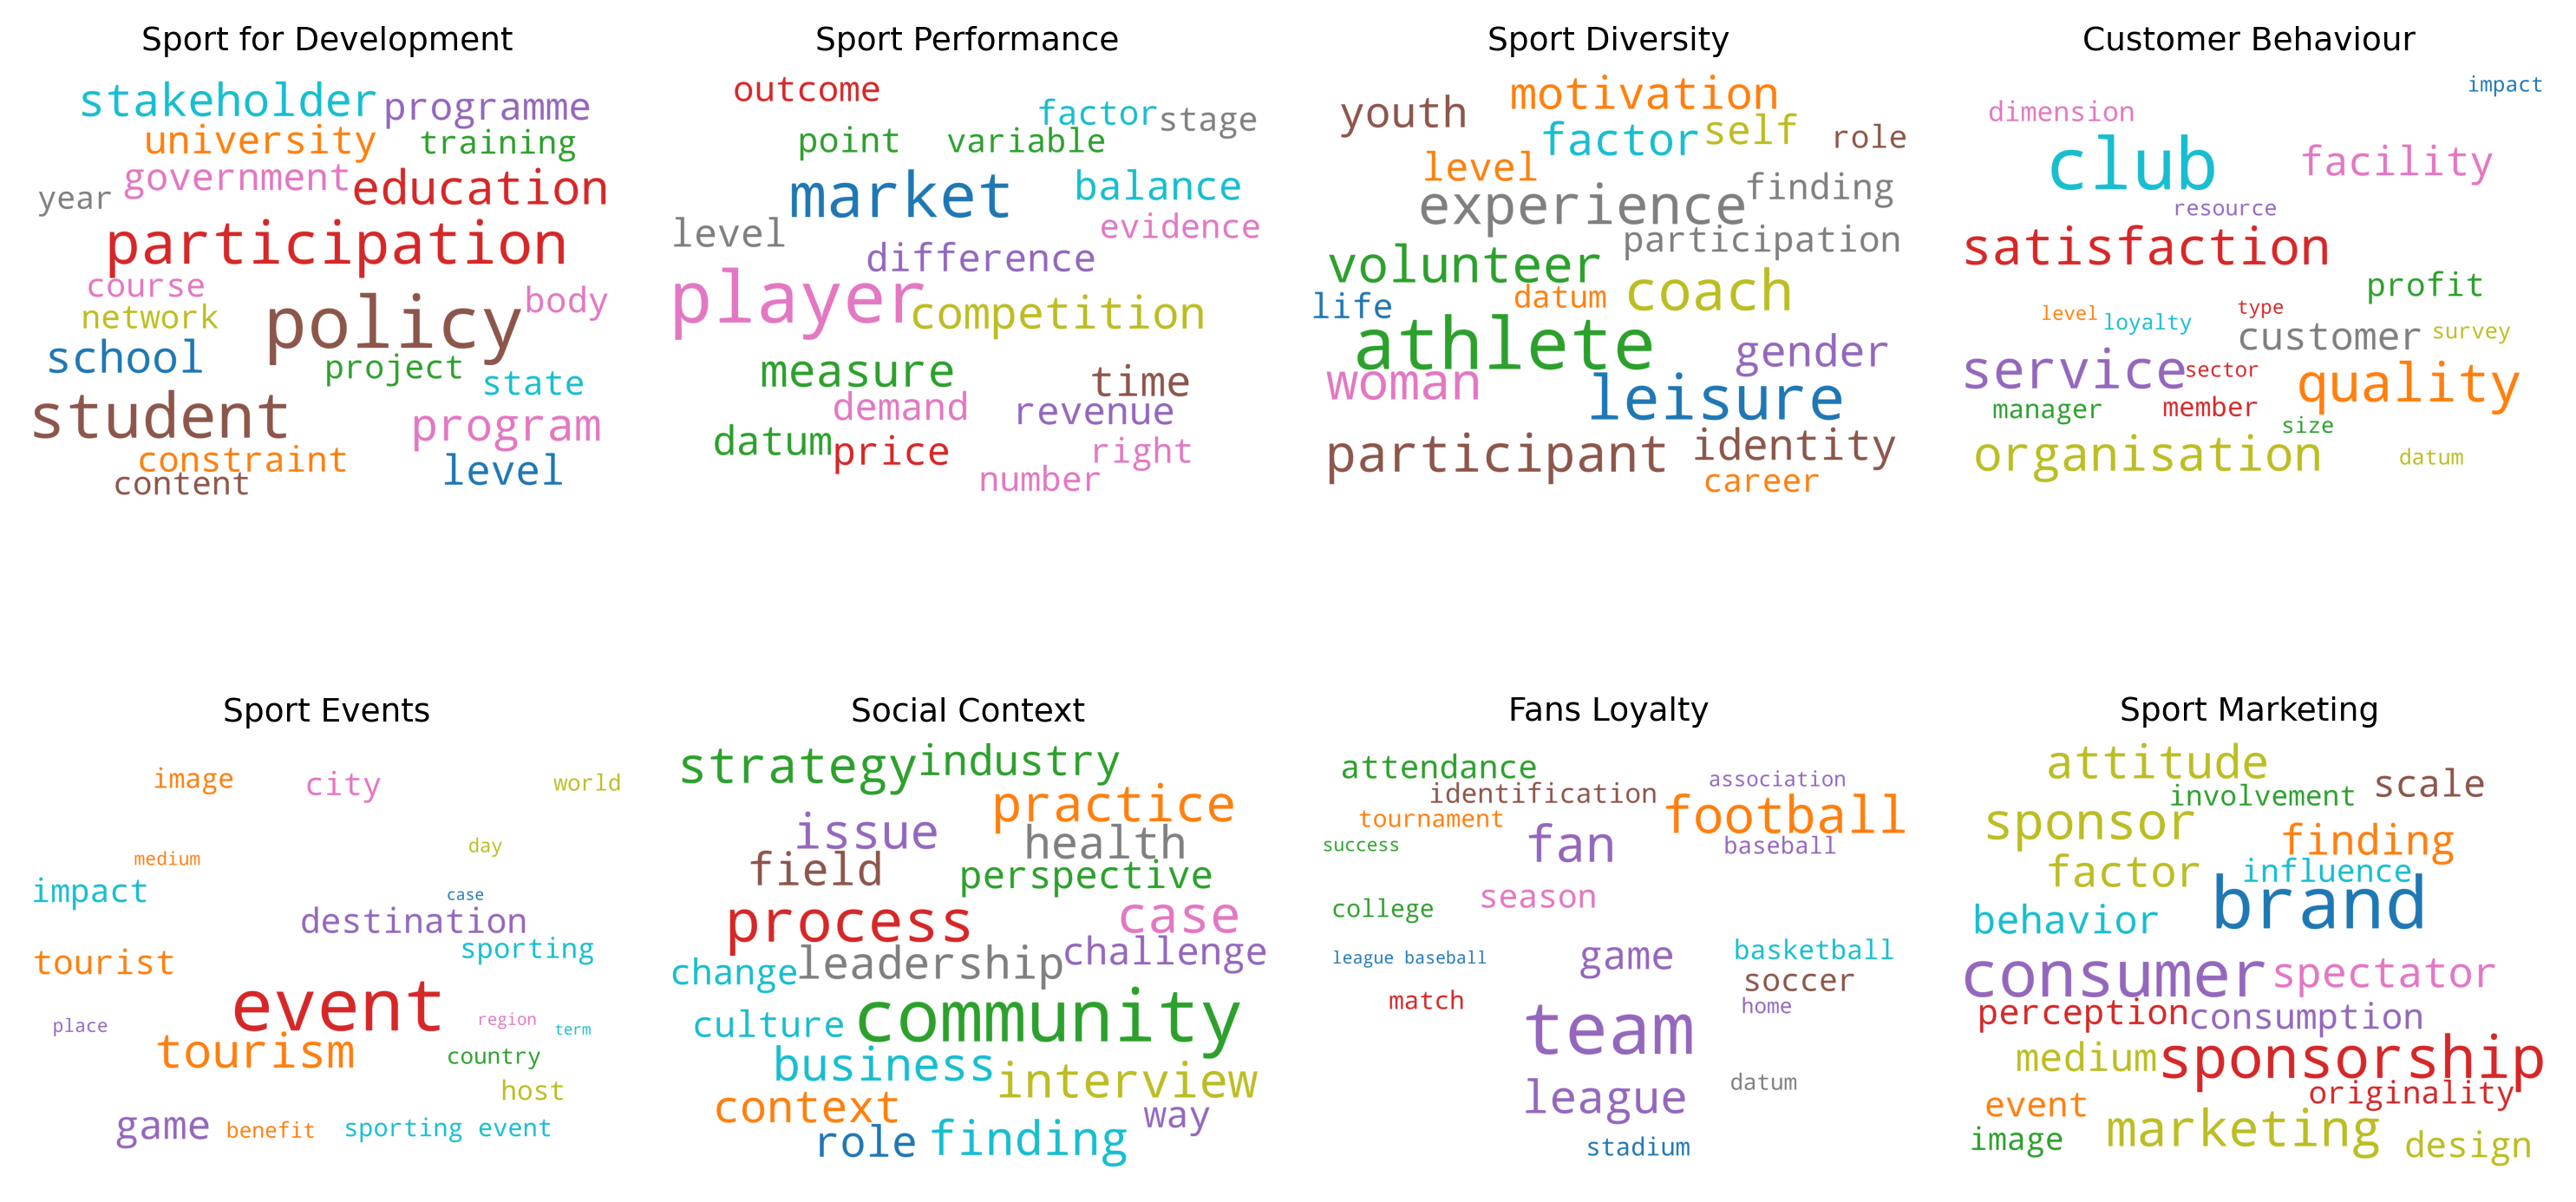

In [44]:
start_topic = 0
 
fig, axes = plt.subplots(2, 4, figsize=(10,6), sharex=True, sharey=True, dpi = 300)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = keywords_frequency[i + start_topic]
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topicnames[i], fontdict=dict(size=9))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,policy,student,participation,education,stakeholder,program,school,level,university,programme
Topic 1,player,market,measure,competition,time,datum,balance,price,level,revenue
Topic 2,athlete,leisure,coach,experience,participant,woman,volunteer,motivation,factor,gender
Topic 3,club,service,quality,satisfaction,organisation,facility,customer,profit,dimension,member
Topic 4,event,tourism,game,destination,tourist,impact,city,sporting,image,host
Topic 5,community,process,case,practice,strategy,issue,interview,finding,business,health
Topic 6,team,football,fan,league,game,season,attendance,soccer,identification,basketball
Topic 7,brand,consumer,sponsorship,sponsor,marketing,attitude,factor,spectator,finding,behavior


##### Topic coherence

##### Normalized topic entropy [0 : 1.0]

$H_i = - \frac{1}{\ln{n_w}} * \sum_{i}^{n_w}{p(w_i)\ln{p(w_i)}}$

$n_w$ - number of features (words)
$p(w_i)$ - coeff of word $i$ in specfific topic

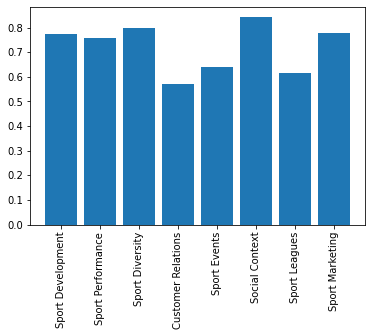

In [ ]:
H = []
t = []
for i,w_distr in enumerate(words_weights_by_topic):
    h = 0
    for w in w_distr:
        h += -w * np.log(w)
    H.append(h / np.log(words_weights_by_topic.shape[1]))
    t.append(i)
fig  = plt.bar(topicnames,H)
_ = plt.xticks(rotation = 90)

In [ ]:
df1 = df.copy()
print(df1.shape)
print(df_document_topic.shape)
df1 = df1.merge(df_document_topic, left_index = True, right_index = True)
df1.shape

(6982, 13)
(6982, 9)


(6982, 22)

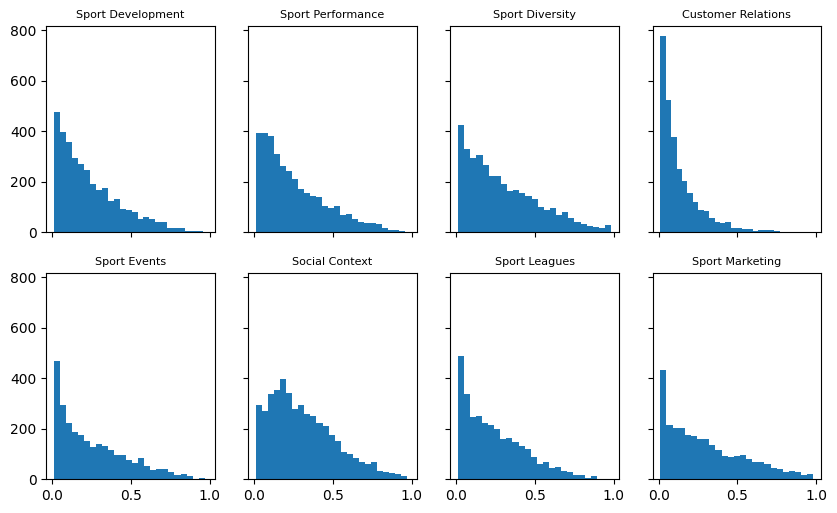

In [ ]:
# Distibution of topic weights across the corpus
fig, axes = plt.subplots(2, 4, figsize=(10,6), sharex=True, sharey=True, dpi = 100)
i = 0
for t,ax in zip(topicnames,axes.flatten()):
    fig.add_subplot(ax)
    plt.hist(df1[t][df1[t] > 0.01], bins = 25)
    plt.title(t,fontsize = 8)

In [ ]:
df1.to_csv(mypath + '/full_with_topics.csv')

#### 2. Topic popularity

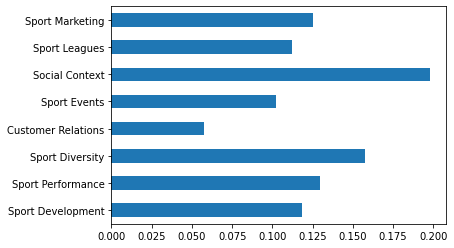

In [ ]:
# Topic overall popularity

(df_document_topic[topicnames].sum() / df.shape[0]).plot.barh();

In [ ]:
(df_document_topic[topicnames].sum() / df.shape[0])

Sport Development     0.118
Sport Performance     0.130
Sport Diversity       0.157
Customer Relations    0.058
Sport Events          0.102
Social Context        0.198
Sport Leagues         0.112
Sport Marketing       0.125
dtype: float64

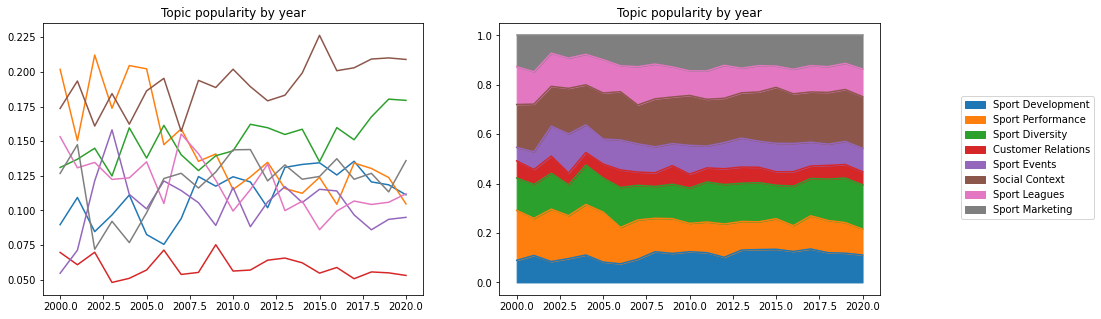

In [ ]:
# Topic popularity by year
df3 = df1.groupby('Year')[topicnames].sum().T / df1.Year.value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
df3.T.plot(ax=axes[0], legend = False); axes[0].set_title('Topic popularity by year');
df3.T.plot.area(ax=axes[1]).legend(bbox_to_anchor=(1.2, 0.75)); axes[1].set_title('Topic popularity by year');

In [ ]:
# Trend lines (beta coefficients) for topic popularity

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

for t in topicnames:
    x = np.array(df3.loc[t].index).reshape(-1, 1)
    y = df3.loc[t].values
    lr.fit(x,y)
    print(t,':',lr.coef_)

Sport Development : [0.002]
Sport Performance : [-0.0044]
Sport Diversity : [0.0017]
Customer Relations : [-0.0004]
Sport Events : [-9.9654e-05]
Social Context : [0.002]
Sport Leagues : [-0.002]
Sport Marketing : [0.0013]


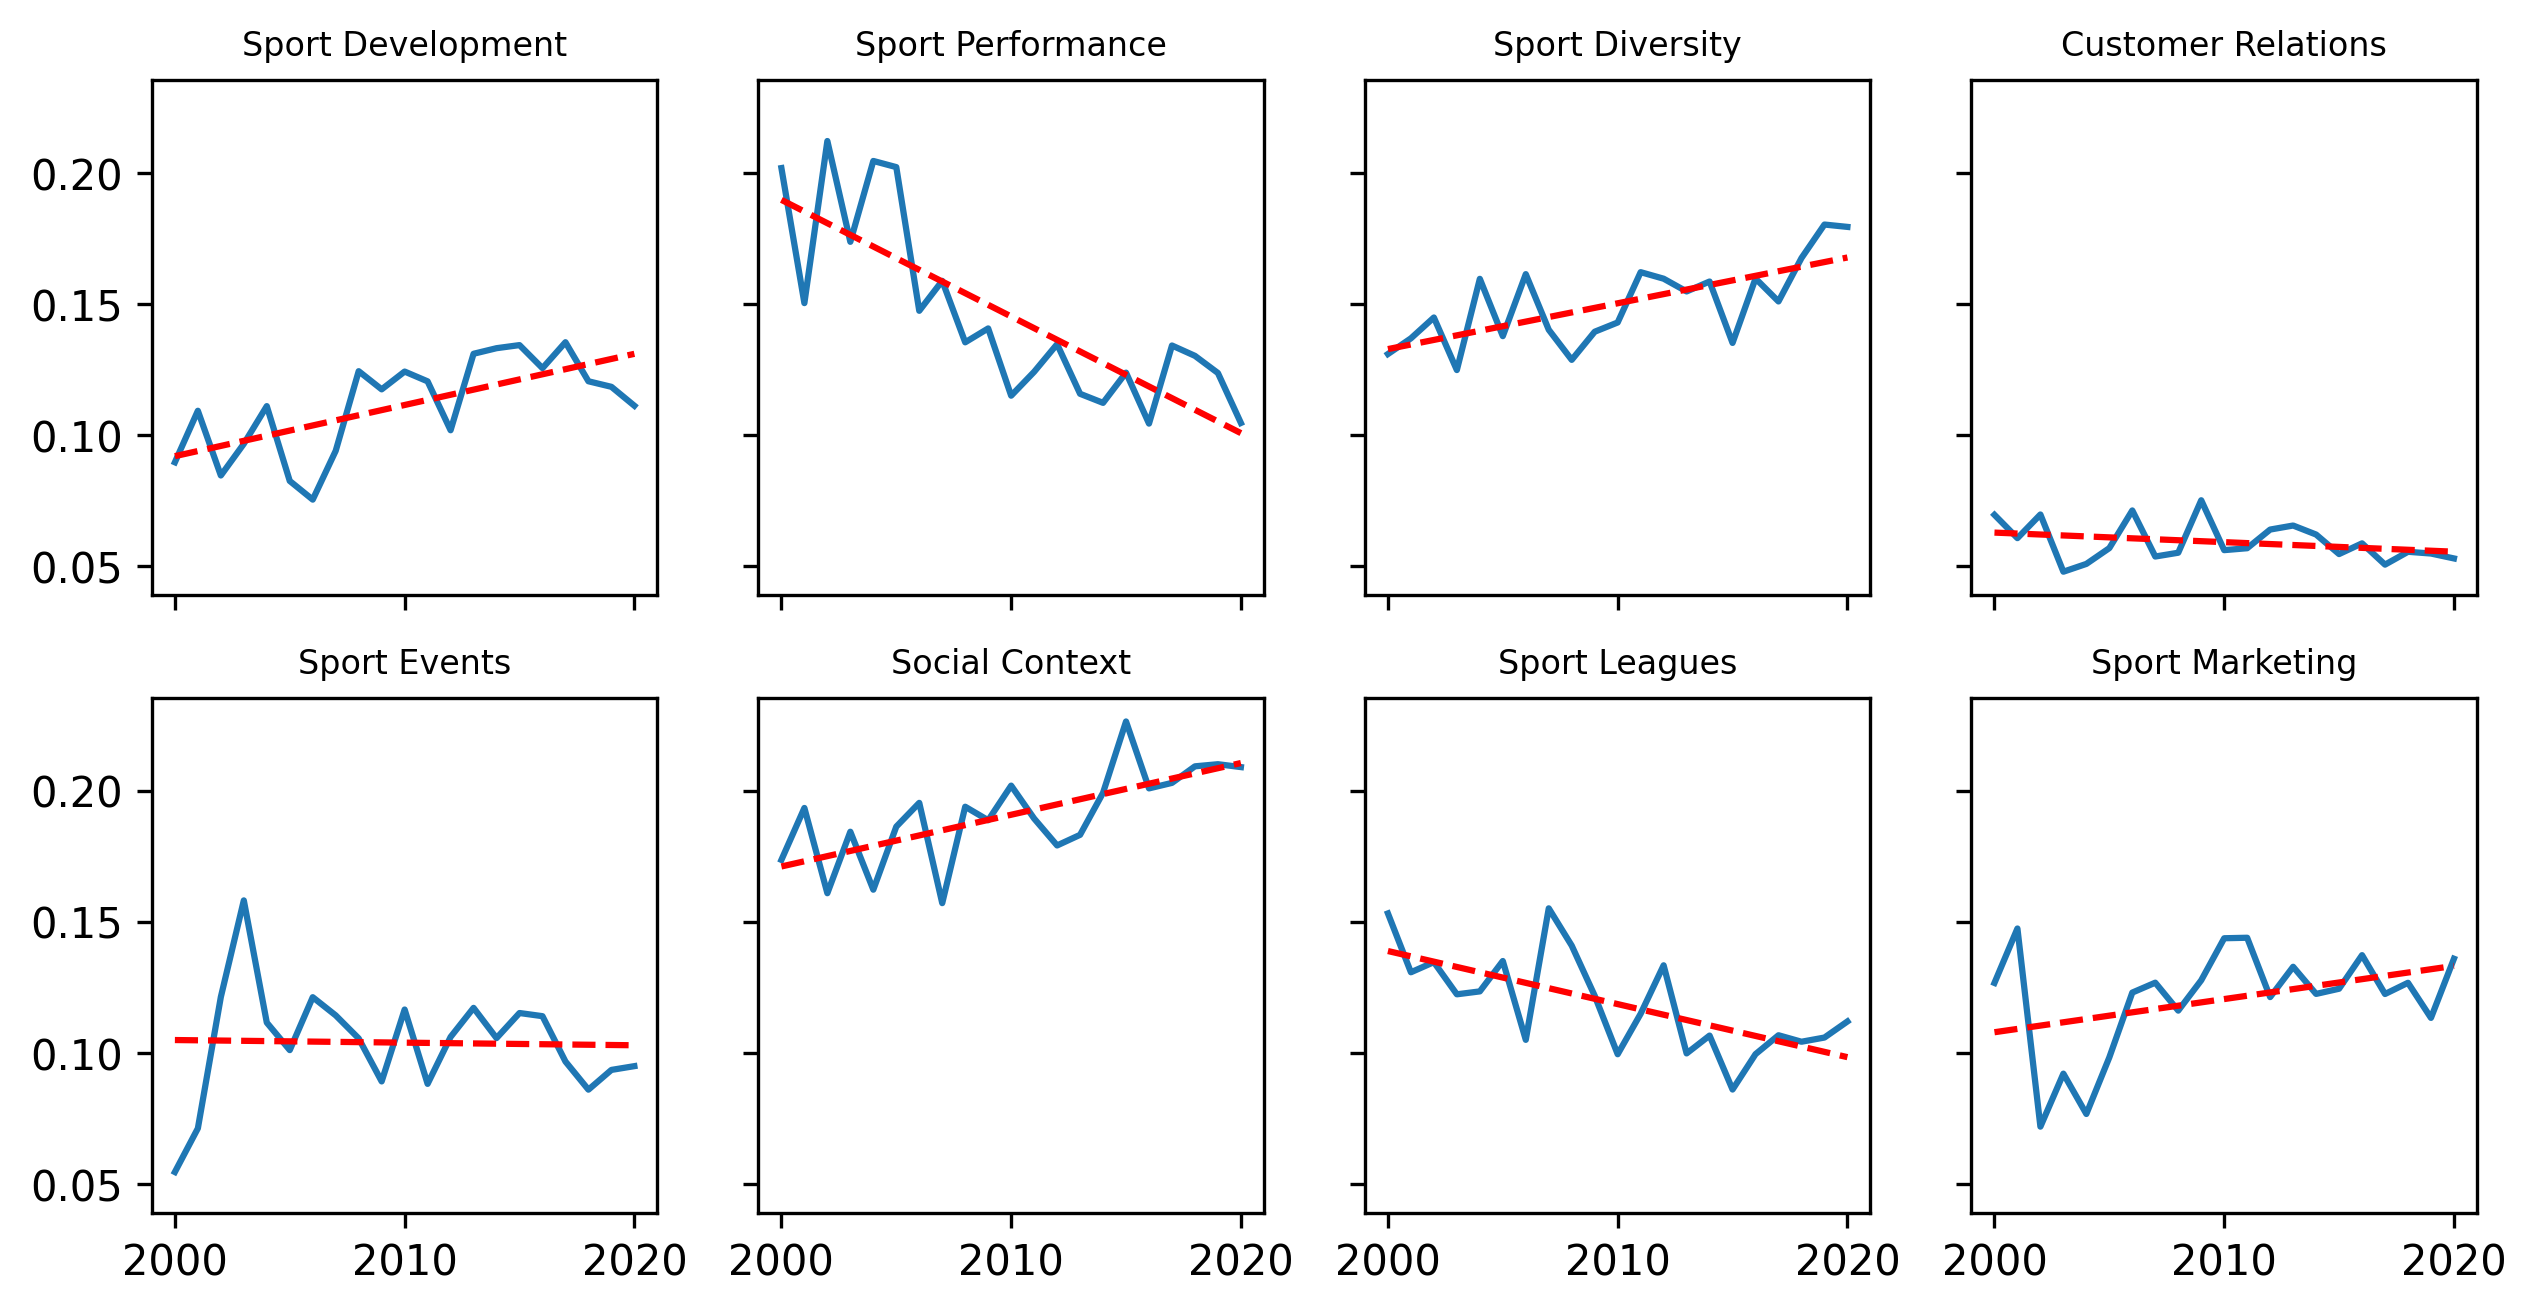

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True, dpi = 300)
i = 0
for t,ax in zip(topicnames,axes.flatten()):
    fig.add_subplot(ax)

    x = np.array(df3.loc[t].index).reshape(-1, 1)
    y = df3.loc[t].values
    lr.fit(x,y)
    plt.plot(x, y)
    plt.plot(x, lr.predict(x),'r--')
    plt.title(topicnames[i], fontsize = 8)
    i += 1

#### 3. Topic impact

In [ ]:
# Overall topic impact

m = np.array(df1[topicnames]) 
v = np.array(df1.Cited)
df4 = pd.DataFrame(m * v[:, np.newaxis], columns = topicnames)
df4['Year'] = df1.Year
df4['Cited'] = df1.Cited
print(df4.shape)
df4[topicnames].sum() / df4.Cited.sum()

(6982, 10)


Sport Development     0.096
Sport Performance     0.117
Sport Diversity       0.149
Customer Relations    0.066
Sport Events          0.142
Social Context        0.185
Sport Leagues         0.108
Sport Marketing       0.137
dtype: float64

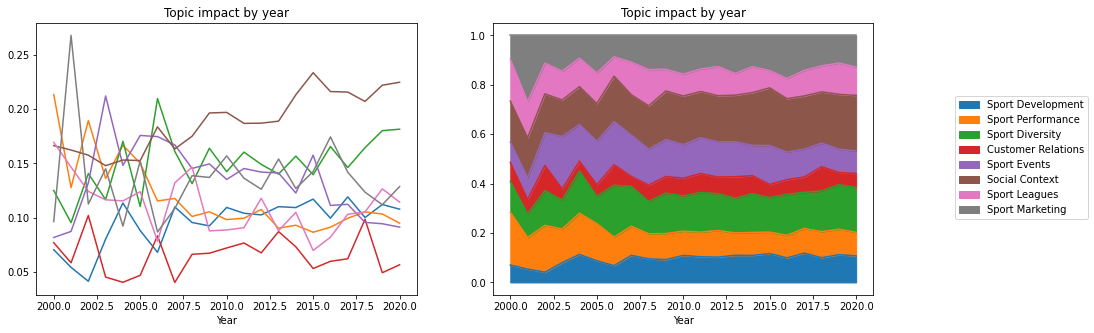

In [ ]:
df5  = df4.groupby('Year')[topicnames].sum().T / df4.groupby('Year').Cited.sum()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
df5.T.plot(ax=axes[0], legend = False); axes[0].set_title('Topic impact by year');
df5.T.plot.area(ax=axes[1]).legend(bbox_to_anchor=(1.2, 0.75)); axes[1].set_title('Topic impact by year');

In [ ]:
# Trend lines (beta coefficients) for topic impact
lr = LinearRegression()

for t in topicnames:
    x = np.array(df5.loc[t].index).reshape(-1, 1)
    y = df5.loc[t].values
    lr.fit(x,y)
    print(t,':',lr.coef_)

Sport Development : [0.0025]
Sport Performance : [-0.0042]
Sport Diversity : [0.0021]
Customer Relations : [8.2671e-05]
Sport Events : [-0.0019]
Social Context : [0.0039]
Sport Leagues : [-0.002]
Sport Marketing : [-0.0004]


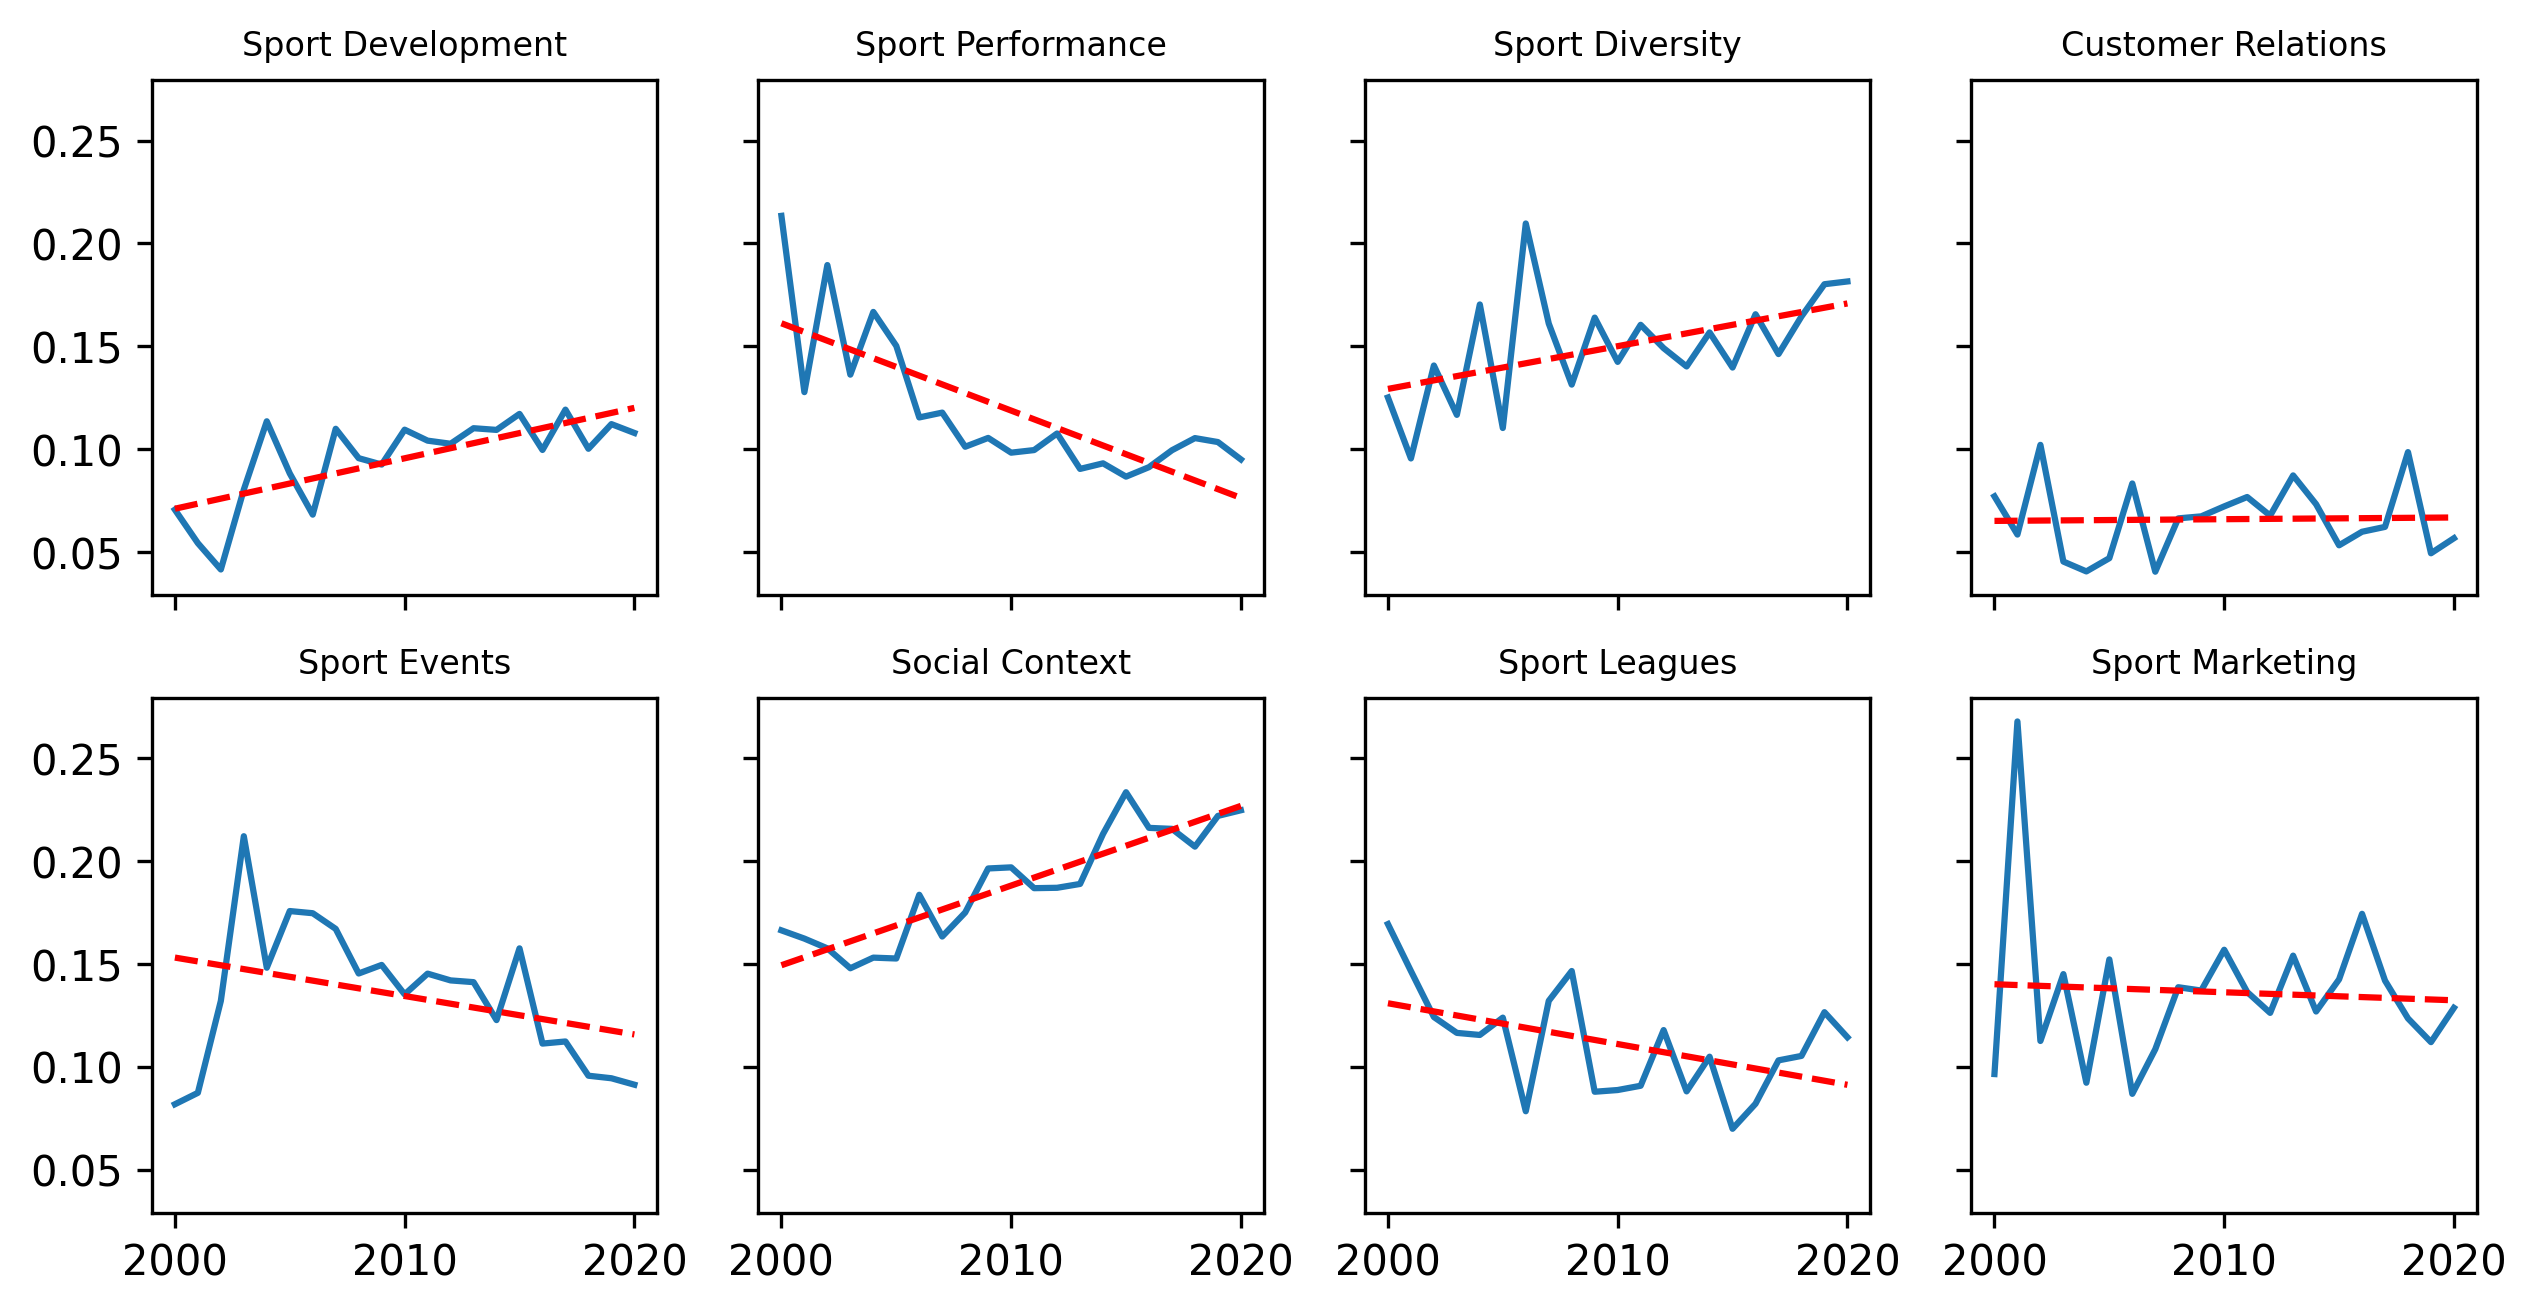

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True, dpi = 300)
i = 0
for t,ax in zip(topicnames,axes.flatten()):
    fig.add_subplot(ax)

    x = np.array(df5.loc[t].index).reshape(-1, 1)
    y = df5.loc[t].values
    lr.fit(x,y)
    plt.plot(x, y)
    plt.plot(x, lr.predict(x),'r--')
    plt.title(topicnames[i], fontsize = 8)
    i += 1

Text(0.5, 1.0, 'Topics impact by year')

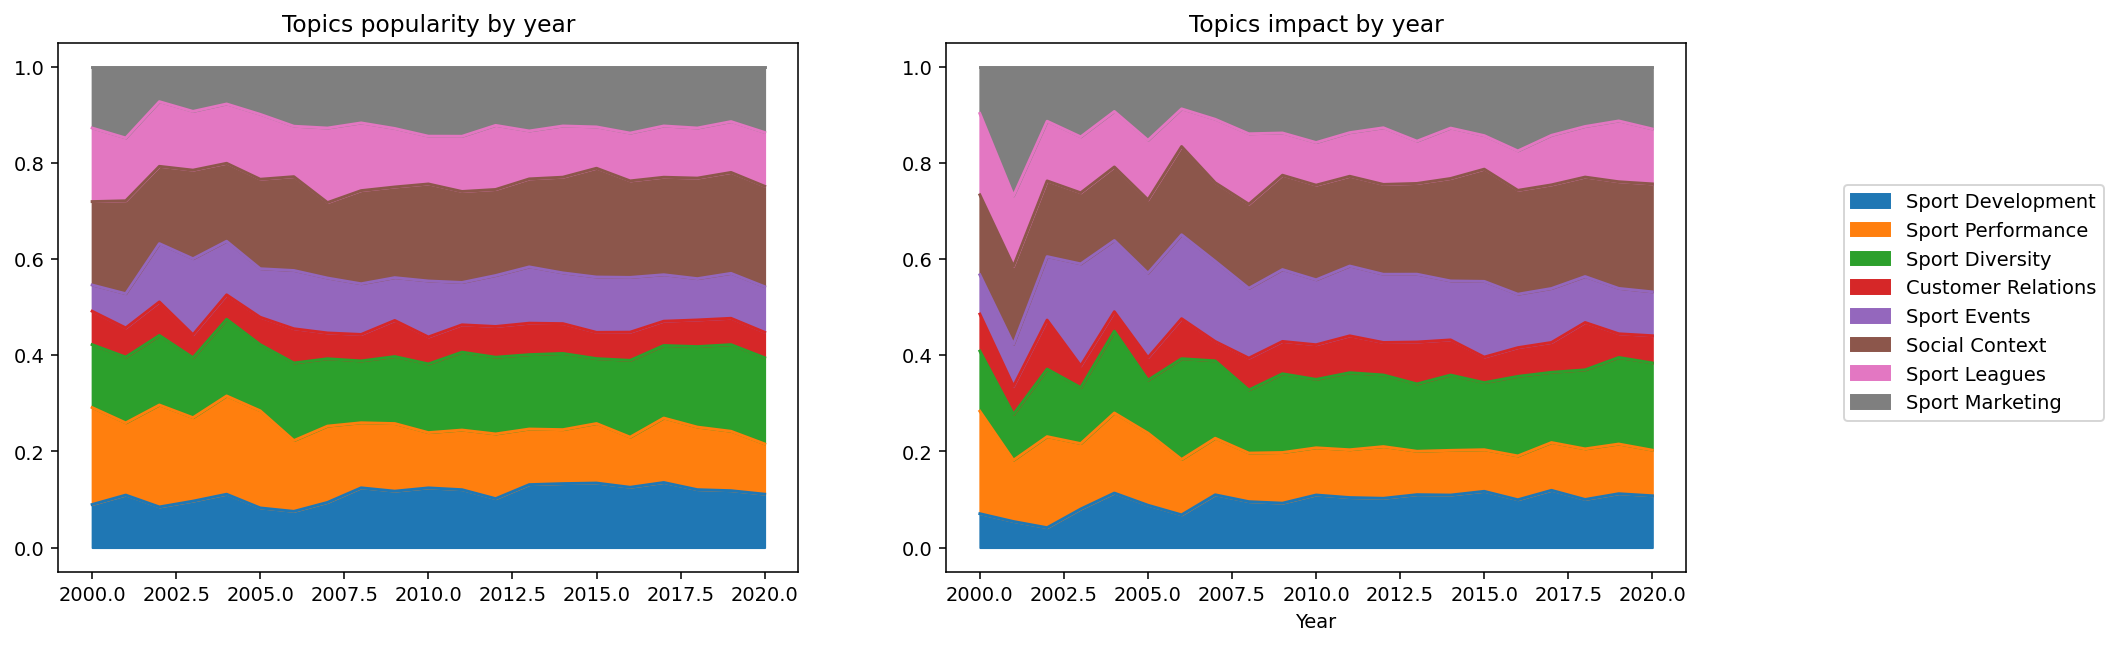

In [ ]:
# Final picture

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5), dpi = 140)
df3.T.plot.area(ax=axes[0], legend = False); axes[0].set_title('Topics popularity by year');
df5.T.plot.area(ax=axes[1]).legend(bbox_to_anchor=(1.2, 0.75)); axes[1].set_title('Topics impact by year')

#### 4.Topic collaboration

In [ ]:
n_tops = best_num_of_topics
np.set_printoptions(precision = 0)
np.set_printoptions(suppress=True)

def dot(a,b):
    r = np.zeros((a.shape[0],b.shape[0]))
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            r[i,j] = a[i] * b[j]
    return r

t_col = np.zeros((n_tops, n_tops))
a = df1[topicnames].values
for r in a:
    t_col += dot(r,r)

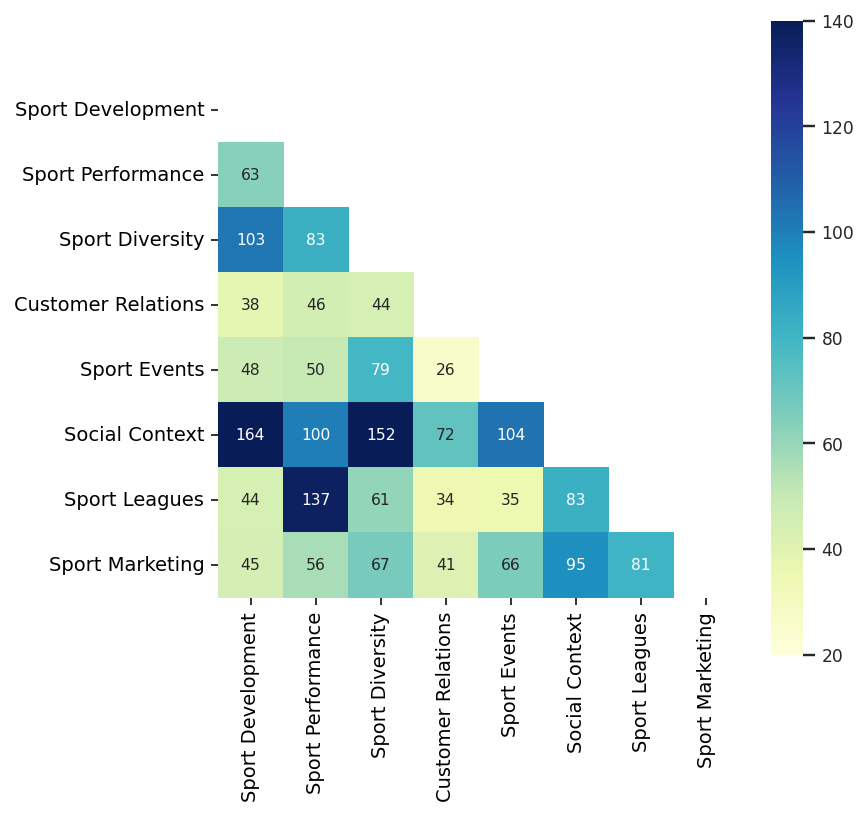

In [ ]:
import seaborn as sns

f, ax = plt.subplots(figsize = (6,6), dpi = 140)
mask = np.zeros_like(t_col)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=0.8)
ax = sns.heatmap(t_col, mask=mask, vmin = 20, vmax = 140, square=True,  
                 annot = True, annot_kws={"fontsize":8}, fmt = '.0f', cmap="YlGnBu",
                 yticklabels = topicnames, xticklabels = topicnames)

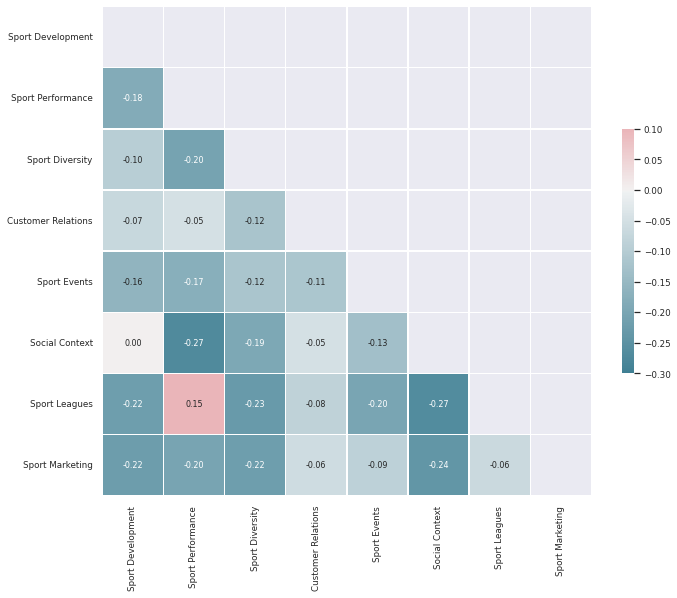

In [ ]:
# Topic correlations

corr = df1[topicnames].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -0.3, vmax=0.1, center=0, square=True, 
            annot = True, annot_kws={"fontsize":8}, fmt = '.2f',
            linewidths=.5, cbar_kws={"shrink": .5});

#### 5. Journal uniqueness

In [ ]:
# Total number of sources
df.loc[df.Source == 'Managing Leisure', 'Source'] = 'Managing Sport and Leisure'
len(df.Source.value_counts())

134

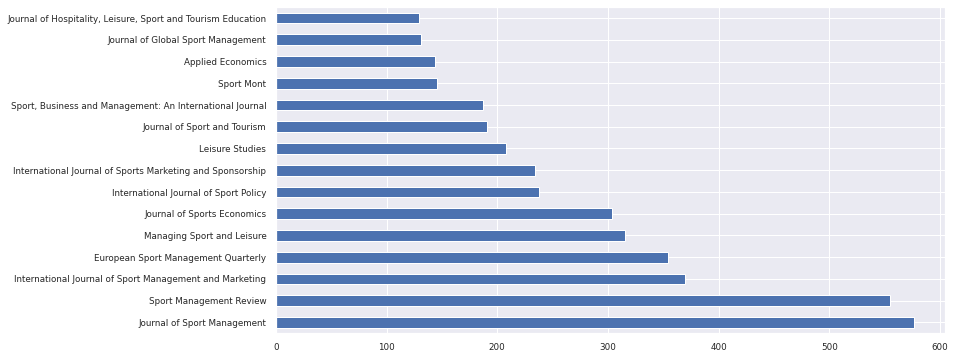

In [ ]:
# Top sources by amount of publications
fig  = df.Source.value_counts()[0:15].plot.barh(figsize = (12,6))

(134, 3)


,Pubs,Citation,Avg_cit
Leisure Sciences,77,2034,26.416
Journal of Sport and Tourism,191,4917,25.743
Journal of Sport Management,576,13901,24.134
Leisure Studies,208,4229,20.332
Sport Management Review,555,11186,20.155
Journal of Sports Economics,304,4866,16.007
International Journal of Sport Policy,238,2918,12.261
European Sport Management Quarterly,354,4006,11.316
Applied Economics,144,1544,10.722
Event Management,110,981,8.918


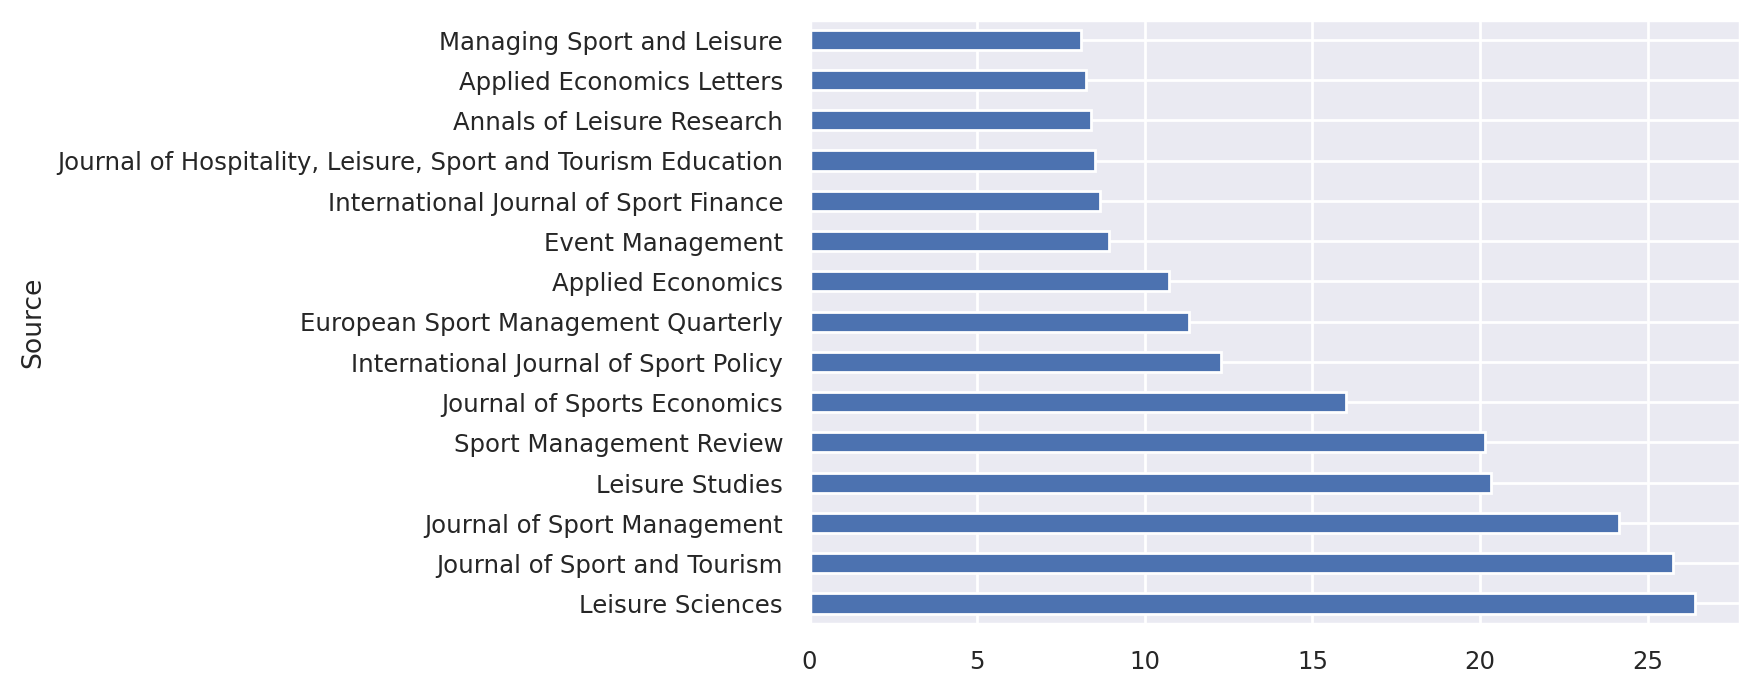

In [ ]:
# Top 15 sources by citation

df_so = pd.merge(df.groupby(by = 'Source').Source.count(), df.groupby(by = 'Source').Cited.sum(), 
                 left_index = True, right_index = True)
df_so.rename(columns = {'Source' : 'Pubs', 'Cited' : 'Citation'}, inplace = True)
df_so['Avg_cit'] = df_so.Citation / df_so.Pubs
print(df_so.shape)

df_so1 = df_so[df_so.Pubs > 70].sort_values(by = 'Avg_cit', ascending = False).head(15)

fig = plt.figure(dpi = 200)
df_so1.Avg_cit.plot.barh(ax = plt.gca(), rot = 0, label = 'Average citation')

df_so1.index.name = None
df_so1.head(15)

In [ ]:
# Distribuiton of topics over journals

sources = df_so1.index.values
df4 = df1[df1.Source.isin(sources)]

df2 = df4.groupby('Source')[topicnames].sum() / df4.groupby('Source').Source.count().values[:, np.newaxis] # Topic profiles for each source
# p_k = \sum_{i=1}^{m_k}{t_ij} / {m_k}; m_k - number of pubs in k-th journal; t_ij - i-th topic coeff in j-th paper in k-th journal
    
df2['Pubs'] = df4.groupby('Source').Source.count()
print('Total number of sources:', df2.shape)

n_top_sources = 15
df3 = df2[topicnames]

Total number of sources: (15, 9)


In [ ]:
df3 = df3.loc[sources]
df3.index.name = None
df3.sort_index(axis = 0).round(3).style.background_gradient(cmap='Blues', axis = 1)

,Sport Development,Sport Performance,Sport Diversity,Customer Relations,Sport Events,Social Context,Sport Leagues,Sport Marketing
Annals of Leisure Research,0.135,0.033,0.429,0.048,0.065,0.236,0.035,0.018
Applied Economics,0.071,0.344,0.064,0.058,0.066,0.065,0.308,0.025
Applied Economics Letters,0.073,0.295,0.068,0.055,0.051,0.053,0.374,0.031
European Sport Management Quarterly,0.110,0.107,0.130,0.082,0.084,0.233,0.108,0.146
Event Management,0.065,0.042,0.184,0.038,0.381,0.160,0.029,0.102
International Journal of Sport Finance,0.097,0.342,0.037,0.068,0.058,0.074,0.267,0.057
International Journal of Sport Policy,0.337,0.070,0.129,0.067,0.050,0.311,0.020,0.016
"Journal of Hospitality, Leisure, Sport and Tourism Education",0.438,0.035,0.171,0.031,0.107,0.177,0.014,0.026
Journal of Sport Management,0.101,0.087,0.163,0.047,0.075,0.246,0.115,0.167
Journal of Sport and Tourism,0.047,0.046,0.171,0.041,0.435,0.156,0.041,0.063


In [ ]:
# Distribuiton of topics over journals in year = 2020

df4 = df1[df1.Source.isin(sources)]
df4 = df4[df4.Year == 2020]

df21 = df4.groupby('Source')[topicnames].sum() / df4.groupby('Source').Source.count().values[:, np.newaxis] # Topic profiles for each source

df21 = df21[df21.index.isin(sources)]
df21.index.name = None
df21.sort_index(axis = 0).round(3).style.background_gradient(cmap='Blues', axis = 1)

,Sport Development,Sport Performance,Sport Diversity,Customer Relations,Sport Events,Social Context,Sport Leagues,Sport Marketing
Annals of Leisure Research,0.129,0.028,0.300,0.039,0.082,0.389,0.027,0.006
Applied Economics,0.069,0.375,0.085,0.110,0.026,0.012,0.281,0.043
Applied Economics Letters,0.027,0.174,0.032,0.022,0.063,0.110,0.541,0.031
European Sport Management Quarterly,0.107,0.110,0.120,0.076,0.077,0.208,0.126,0.176
Event Management,0.042,0.013,0.186,0.049,0.367,0.195,0.009,0.140
International Journal of Sport Finance,0.005,0.312,0.025,0.049,0.123,0.106,0.376,0.005
"Journal of Hospitality, Leisure, Sport and Tourism Education",0.442,0.005,0.292,0.005,0.005,0.199,0.005,0.046
Journal of Sport Management,0.072,0.080,0.220,0.066,0.077,0.256,0.111,0.118
Journal of Sport and Tourism,0.033,0.037,0.174,0.062,0.492,0.129,0.006,0.067
Journal of Sports Economics,0.109,0.290,0.106,0.102,0.117,0.012,0.256,0.008


#### 7. Most representative paper for each topic

In [ ]:
no_of_papers = 5

df_paper = pd.DataFrame()
for topic in topicnames:
    papers = df1.sort_values(by = [topic,'Cited'], ascending = False).head(no_of_papers)
    
    df_paper = pd.concat([df_paper, papers], ignore_index = True)

df_paper.to_csv('repr_papers.csv', sep = ';', decimal = ',', index = True)

In [ ]:
df_paper.head(10)

,Authors,Title,Year,Source,Volume,Issue,Article N,Page_start,Page_end,Cited,...,Type,Sport events,Performance management,Social strategies,Participation patterns,Dependency Analysis,Psychology,Sport Motivation,Fans and Advertisement,dominant_topic
0,Chaney P.,Electoral discourse and the party politicizati...,2015,International Journal of Sport Policy,7,2,NaN,159.0,180,1,...,Article,0.960,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0
1,"Houghton L.J., Williams E.L., Jones H.S., Page...",To align or not to align? Research methods and...,2017,"Journal of Hospitality, Leisure, Sport and Tou...",20,NaN,NaN,101,109,1,...,Article,0.937,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0
2,"Woolf J., Dixon J.C.",You're hired! a hiring simulation for sport ma...,2017,Sport Management Education Journal,11,2,NaN,106,119,1,...,Article,0.927,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0
3,"Li H., Meng L., Wang Q.",The government's role in China's Olympic glory,2009,Applied Economics,41,25,NaN,3313,3318,6,...,Article,0.927,0.010,0.010,0.010,0.010,0.010,0.010,0.010,0
4,Bablak K.,Determinants of interorganizational relationsh...,2007,Journal of Sport Management,21,3,NaN,338,376,68,...,Article,0.912,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0
5,"Rodríguez-Gutiérrez C., Fernández-Blanco V.",Continuous TV demand in road cycling: the 2015...,2017,European Sport Management Quarterly,17.0,3,NaN,349.0,369.0,5,...,Article,0.006,0.960,0.006,0.006,0.006,0.006,0.006,0.006,1
6,"Polat S.C., Cetin E., Yarim I., Bulgay C., Cic...",Effect of ballistic warm-up on isokinetic stre...,2018,Sport Mont,16,3,NaN,85,89,0,...,Article,0.008,0.942,0.008,0.008,0.008,0.008,0.008,0.008,1
7,"Barnett T., Clarke S.R.",Combining player statistics to predict outcome...,2005,IMA Journal of Management Mathematics,16,2,NaN,113,120,27,...,Article,0.010,0.933,0.010,0.010,0.010,0.010,0.010,0.010,1
8,"Dreber A., Gerdes C., Gränsmark P., Little A.C.",Facial masculinity predicts risk and time pref...,2013,Applied Economics Letters,20,16,NaN,1477,1480,5,...,Article,0.010,0.933,0.010,0.010,0.010,0.010,0.010,0.010,1
9,"Zubair M., Maqsood H.S., Neckar B.",Impact of filling yarns on woven fabric perfor...,2016,Fibres and Textiles in Eastern Europe,24,5,NaN,50.0,54,0,...,Article,0.011,0.920,0.011,0.011,0.011,0.011,0.011,0.011,1


In [ ]:
# Most cited paper in each topic

no_of_papers = 10

df_paper1 = pd.DataFrame()
for topic in range(0,8):
    papers = df1[df1.dominant_topic == topic].sort_values(by = 'Cited', ascending = False).head(no_of_papers)
    
    df_paper1 = pd.concat([df_paper1, papers], ignore_index = True)

df_paper1.head(10)

,Authors,Title,Year,Source,Volume,Issue,Article N,Page_start,Page_end,Cited,...,Type,Sport events,Performance management,Social strategies,Participation patterns,Dependency Analysis,Psychology,Sport Motivation,Fans and Advertisement,dominant_topic
0,"Darling N., Caldwell L.L., Smith R.",Participation in school-based extracurricular ...,2005,Journal of Leisure Research,37,1,NaN,51,76,140,...,Article,0.573,0.160,0.004,0.004,0.004,0.004,0.004,0.246,0
1,"Hammitt W.E., Backlund E.A., Bixler R.D.","Experience use history, place bonding and reso...",2004,Journal of Leisure Research,36,3,NaN,356,378,129,...,Article,0.509,0.005,0.242,0.005,0.005,0.005,0.005,0.224,0
2,"Grix J., Carmichael F.",Why do governments invest in elite sport? A po...,2012,International Journal of Sport Policy,4,1,NaN,73,90,118,...,Article,0.705,0.118,0.006,0.006,0.006,0.147,0.006,0.006,0
3,"Johnson B.K., Whitehead J.C.",Value of public goods from sports stadiums: Th...,2000,Contemporary Economic Policy,18,1,NaN,48,58,113,...,Article,0.514,0.007,0.007,0.007,0.007,0.007,0.446,0.007,0
4,"Downward P., Riordan J.",Social interactions and the demand for sport: ...,2007,Contemporary Economic Policy,25,4,NaN,518,537,102,...,Article,0.672,0.009,0.274,0.009,0.009,0.009,0.009,0.009,0
5,"Goldstein D.G., Gigerenzer G.",Fast and frugal forecasting,2009,International Journal of Forecasting,25,4,NaN,760,772,100,...,Article,0.555,0.021,0.021,0.021,0.021,0.320,0.021,0.021,0
6,"Humphreys B.R., Ruseski J.E.",Participation in physical activity and governm...,2007,Contemporary Economic Policy,25,4,NaN,538,552,91,...,Article,0.700,0.190,0.006,0.006,0.006,0.080,0.006,0.006,0
7,Lipscomb S.,Secondary school extracurricular involvement a...,2007,Economics of Education Review,26,4,NaN,463,472,91,...,Article,0.394,0.304,0.131,0.153,0.005,0.005,0.005,0.005,0
8,"Stodolska M., Alexandris K.",The role of recreational sport in the adaptati...,2004,Journal of Leisure Research,36,3,NaN,379,413,90,...,Article,0.486,0.006,0.006,0.006,0.006,0.480,0.006,0.006,0
9,"Pope D.G., Pope J.C.",The impact of college sports success on the qu...,2009,Southern Economic Journal,75,3,NaN,750,780,89,...,Article,0.766,0.003,0.003,0.057,0.003,0.003,0.161,0.003,0


In [ ]:
df_paper1.to_excel(mypath + '/representative_papers.xlsx')

#### 8. Topic distribution for specific paper

Parris D.L. (2013) Conceptually meeting expectations of Generation y by building personalised-customised hybrid bundles to target action sports consumers . International Journal of Revenue Management . 7  (2):138  - 154  cited     4



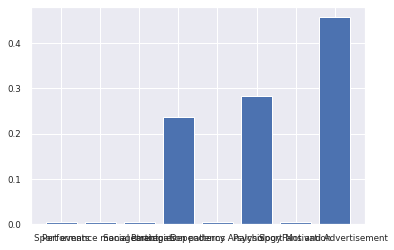

In [ ]:
paper_ind = 3764
paper_ = df1.loc[paper_ind]

print(paper_[0], '({:4d})'.format(paper_[2]), paper_[1],'.', paper_[3], '.',
      '{:3s}({:1s}):{:4s} - {:4s}'.format(str(paper_[4]), str(paper_[5]), str(paper_[7]), str(paper_[8])),
      'cited {:5d}'.format(paper_[9]))
print()

_ = plt.bar(np.arange(0,len(topicnames)), paper_[topicnames])
_ = plt.xticks(np.arange(0,len(topicnames)), topicnames)

In [ ]:
paper_

Authors                                                         Parris D.L.
Title                     Conceptually meeting expectations of Generatio...
Year                                                                   2013
Source                          International Journal of Revenue Management
Volume                                                                    7
Issue                                                                     2
Article N                                                               NaN
Page_start                                                              138
Page_end                                                                154
Cited                                                                     4
Abstract                  This paper conceptually explores how bundling ...
Keywords                  Action sports; Branding coolness; Bundling; Cu...
Type                                                                Article
Sport events

#### 9. Documents diversity

$D_{d} = - \sum_{i}^{t}{\theta_{di}\ln{\theta_{di}}}$

$t$ is set of topics, $\theta_{di}$ is weight of $i$-th topic in document $d$.

In [ ]:
df5 = df1.copy()

df5['Diversity'] = -(df1[topicnames] * np.log(df1[topicnames])).sum(axis = 1)

Gilbert G.R., Veloutsou C. (2006) A cross-industry comparison of customer satisfaction . Journal of Services Marketing . 20 (5) cited    70



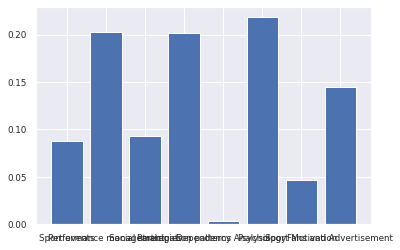

In [ ]:
# Topic distribution for paper with max diversity

paper_ind = np.argmax(df5.Diversity)
paper_ = df5.loc[paper_ind]

print(paper_[0], '({:4d})'.format(paper_[2]), paper_[1],'.', paper_[3], '.',
      '{:3s}({:1s})'.format(paper_[4], paper_[5]),
      'cited {:5d}'.format(paper_[9]))
print()

_ = plt.bar(np.arange(0,len(topicnames)), paper_[topicnames])
_ = plt.xticks(np.arange(0,len(topicnames)), topicnames)

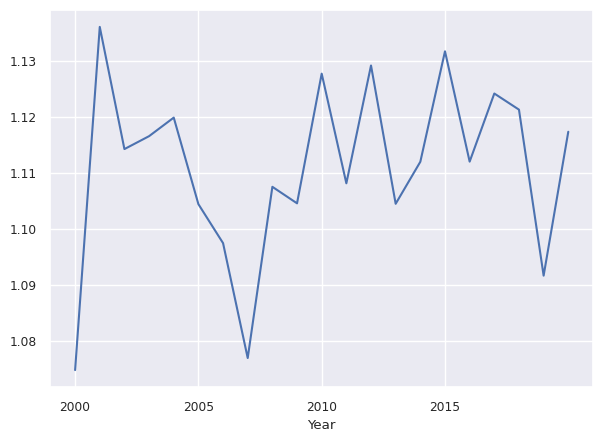

In [ ]:
# Mean document diversity by year

plt.figure(figsize = (7,5), dpi = 100)
df5.groupby(by = 'Year').Diversity.mean().plot(x_compat=True)
_ = plt.xticks(np.arange(2000,2020,5), ['2000', '2005', '2010','2015'])

#### Analysis by Author

In [ ]:
authors = ['Chalip L.', 'Szymanski S.', 'James J.', 'Funk D.', 'Shaw S.', 'Gibson H.J.', "O'Brien D.", 'Taylor T.']

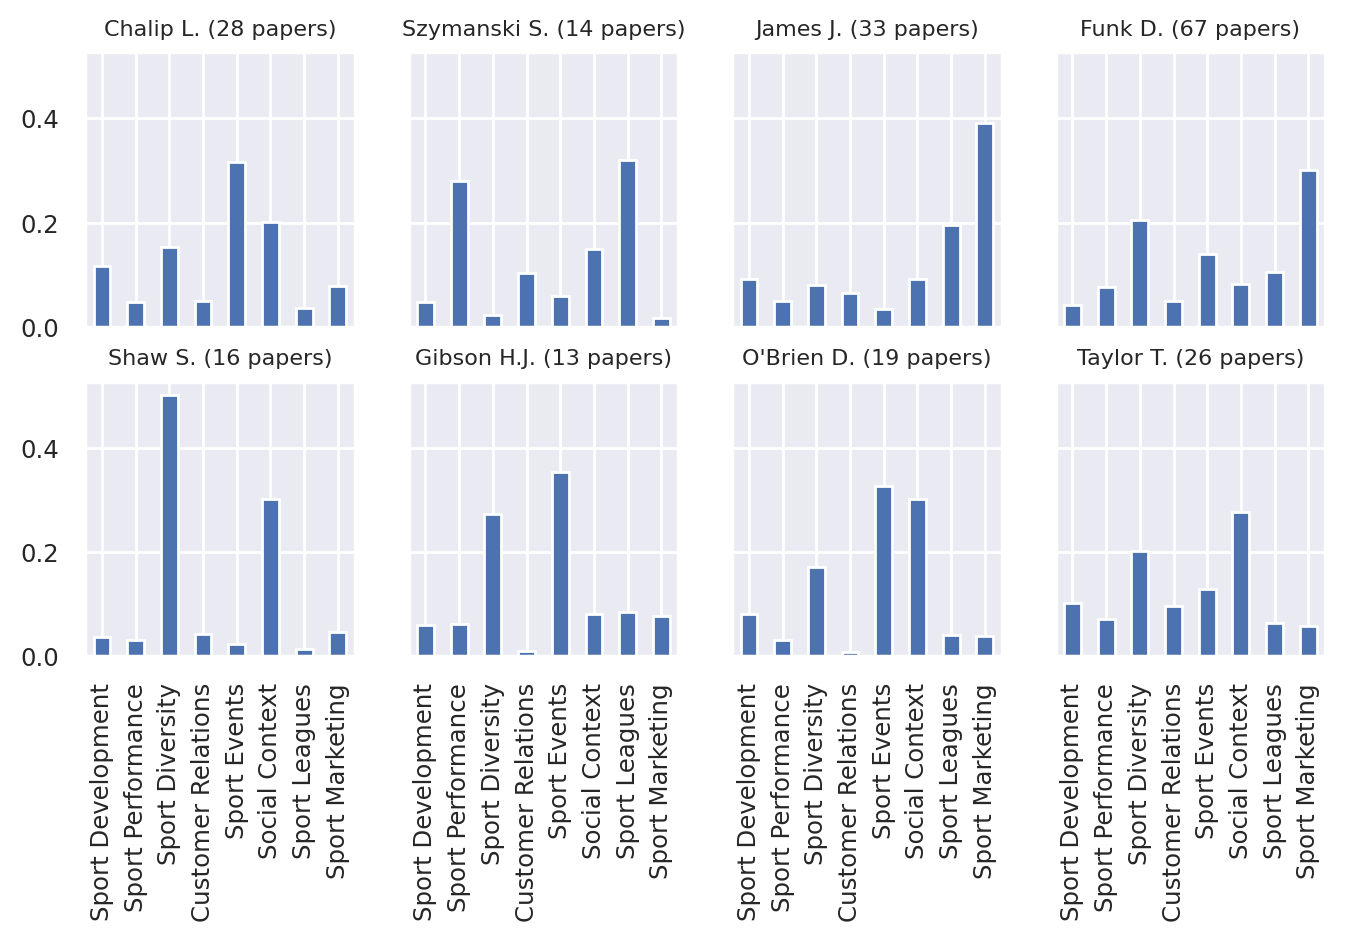

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(8,4), sharex=True, sharey=True, dpi = 200)

for auth,ax in zip(authors,axes.flatten()):
    fig.add_subplot(ax)
    
    mask_auth = df1['Authors'].str.contains(auth)
    no_papers = df1[mask_auth].shape[0]

    (df1[mask_auth][topicnames].sum(axis = 0) / no_papers).plot.bar(ax = ax)
    plt.title(auth + ' (' + str(no_papers) + ' papers)', fontsize = 8)